#  <font color='blue'>Titanic Dataset Problem: a tutorial on a classification problem </font>  

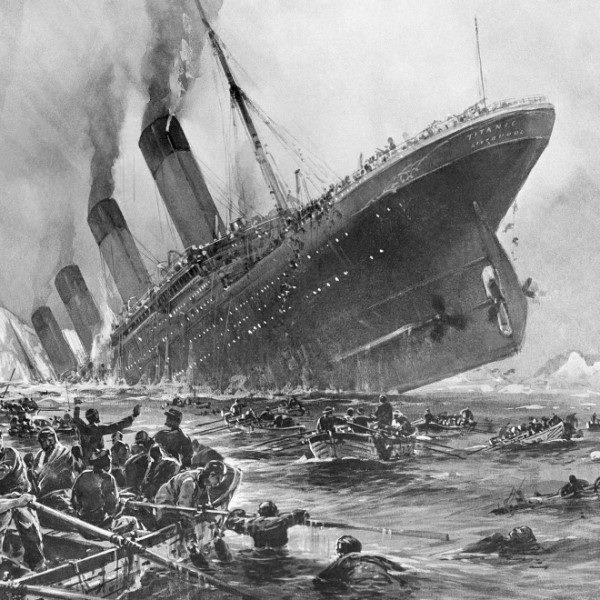

## *Julien Genovese* 
*November 2020*

##  Introduction

In this notebook we deal with the Titanic dataset, a classical problem on [Kaggle](https://www.kaggle.com/c/titanic/overview).

We have a dataset of people present on the Titanic during the famous disaster. Each person has some features like sex, ticket class, age and some other ones and with them we want to predict his survival.

We want to use this problem to introduce the classification problem in general, therefore the metrics, the algorithms and so on. 



In particular we will follow this path:

1. Exploratory Data Analysis: we explore the dataset with some data visualization.
2. Filling the NA values: we see two techniques to fill the missing values in the dataset.
3. Modeling and Error Analysis: we use four models and compare them, analyzing the best model with a ROC curve, a precision/recall curve and so on.
4. Predict new values: predict a new set to obtain a kaggle score.


If you like this tutorial you can join our community in [Meetup](https://www.meetup.com/it-IT/Machine-Learning-Together-Milan/?_locale=it-IT).

If you have doubts contact me at juliengenovese@hotmail.it

## Loading libraries and data

Let's start loading the libraries we will use. 

We explain only the most important libraries. The other ones are useful for some functions.

<ol>
    <li> <code>tidyverse</code> and <code>magrittr</code> are very useful to manage dataframes. They are at the base of data science in R.</li>
    <li> <code>Caret</code> is one of the most important R packages for machine learning.</li>
    <li> <code>ggplot2</code> is one of the R visualization tools.</li>
    <li><code>doMC</code> is the library for parallel computation.</li>
</ol>

In [1]:
library(tidyverse)
library(caret)
library(ggplot2)
library(doMC)
library(magrittr)
library(corrplot)
library(psych)
library(PresenceAbsence)
library(pROC)
library(ROCR)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘magrittr’

The follo

We load the training set and the set to predict. 

The training will be used to find the best algorithm while the predict one will be used to obtain the score on Kaggle.

In [164]:
trainSet <- read.csv2("./input/train.csv", sep =",", stringsAsFactors = FALSE)
toPredictSet <- read.csv2("./input/test.csv", sep = ",", stringsAsFactors = FALSE)

We have loaded our data with <code>stringsAsFactors = FALSE</code> because we want to understand when a character is really a factor and when it's an integer.

## 1.1 Exploratory data analysis

### 1.1.1 Exploration of the features and first feature engineering

In this section we will do a brief exploratory analysis to better understand our data. We will focus on the training set. 

Let's start with an understanding of the feature types:

In [3]:
str(trainSet)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : chr  "22" "38" "26" "35" ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : chr  "7.25" "71.2833" "7.925" "53.1" ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


Let's start removing the <code>PassengerId</code> that is unique for each passenger and therefore doesn't give us much information.

In [4]:
trainSet %<>% select(-PassengerId)

Let's first analyze the numerical features and after the categorical ones.

####  Exploration of the numerical features 

We have 4 numerical features: <code>Age</code>, <code>SibSp</code>, <code>Parch</code> and <code>Fare</code>. Let's see the distribution of these variabiles.

Let's start with <code>Age</code>. We first see some of the unique values it has.

In [5]:
unique(trainSet$Age)[1:20]

[1] "22" "38" "26" "35" ""   "54" "2"  "27" "14" "4"  "58" "20" "39" "55" "31"
[16] "34" "15" "28" "8"  "19"

We can transform them in a numeric variable introducing <code>NA</code> when we have <code>""</code>.

In [6]:
trainSet$Age %<>% as.numeric 

Let's see the distribution of the <code>Age</code>.

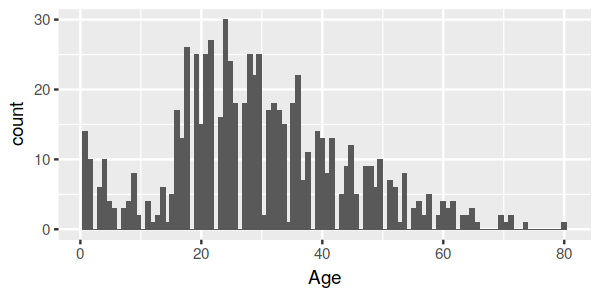

In [7]:
options(repr.plot.width=5, repr.plot.height=2.5)
trainSet[!is.na(trainSet$Age),]  %>% 
  ggplot(mapping = aes(x = Age)) +
  geom_histogram(binwidth = 0.8)

We see that the distribution is concentrared around 30.

We don't see people more than 80 years old.

It seems quite normal distributed.

We move to <code>SibSp</code> and <code>Parch</code>, numerical values associated to the family.

In [8]:
trainSet$SibSp %<>% as.numeric
trainSet$Parch %<>% as.numeric

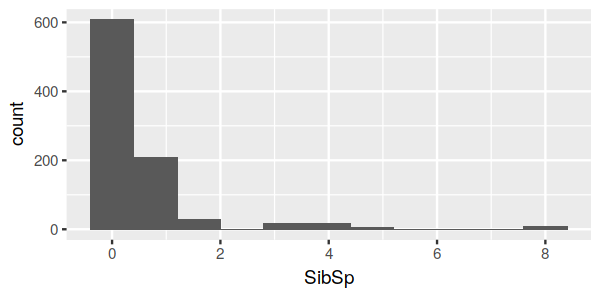

In [9]:
trainSet[!is.na(trainSet$SibSp),] %>% 
  ggplot(mapping = aes(x = SibSp)) +
  geom_histogram(binwidth = 0.8)

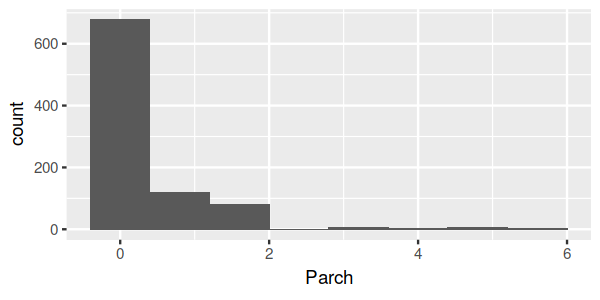

In [10]:
trainSet[!is.na(trainSet$Parch),] %>% 
  ggplot(mapping = aes(x = Parch)) +
  geom_histogram(binwidth = 0.8)

<code>Fare</code> is the last variable that is numeric.

In [11]:
trainSet$Fare %<>% as.numeric 

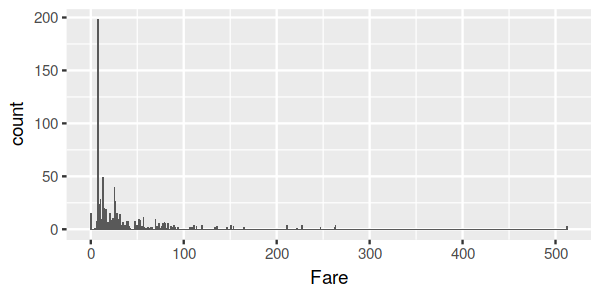

In [12]:
trainSet[!is.na(trainSet$Fare),] %>% 
  ggplot(mapping = aes(x = Fare)) +
  geom_histogram(binwidth = 0.8)

We see that in this case is pretty asymmetric. We later need to **remove this skewness**.

Finally let's see the **numerical correlation** between these variables using a [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

In [13]:
com <- trainSet %>% select(Age, SibSp, Parch, Fare)
cc = cor(com, method = "pearson", use = "pairwise.complete.obs")

In [14]:
cc

,Age,SibSp,Parch,Fare
Age,"1,00000000","-0,3082468","-0,1891193","0,09606669"
SibSp,"-0,30824676","1,0000000","0,4148377","0,15965104"
Parch,"-0,18911926","0,4148377","1,0000000","0,21622494"
Fare,"0,09606669","0,1596510","0,2162249","1,00000000"


We see some relationship between <code>SibSp</code> and <code>Parch</code> and between <code>Age</code> and <code>SibSp</code>.

####  Exploration of the cathegorical features 

In [15]:
str(trainSet)

'data.frame':	891 obs. of  11 variables:
 $ Survived: int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass  : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex     : chr  "male" "female" "female" "female" ...
 $ Age     : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp   : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket  : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare    : num  7,25 71,28 7,92 53,10 8,05 ...
 $ Cabin   : chr  "" "C85" "" "C123" ...
 $ Embarked: chr  "S" "C" "S" "S" ...


In this case we have <code>Survived</code>, <code>Pclass</code>, <code>Name</code>, <code>Sex</code>, <code>Ticket</code>, <code>Cabin</code> and <code>Embarked</code>.

<code>Survived</code> is our target variable and it's a binary variable so we will transform it in a factor.

In [16]:
trainSet$Survived %<>% as.factor

Let's see how many survived people we have.

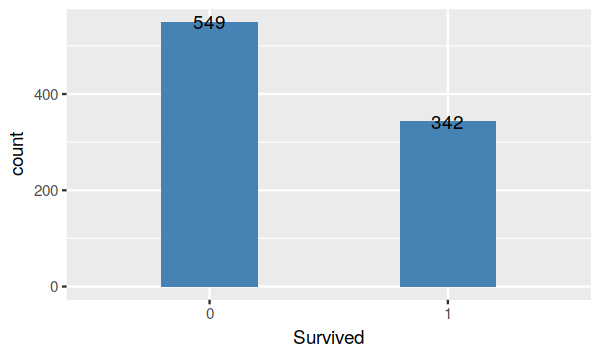

In [17]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(trainSet, aes(Survived)) + 
  geom_bar(width=0.4, fill="steelblue") + 
  geom_text(stat='count', aes(label=..count..), vjust = "center")

Let's see with more details the proportion of the classes.

In [18]:
table(trainSet$Survived)/nrow(trainSet)


        0         1 
0,6161616 0,3838384 

We are dealing with an almost [**balanced dataset**](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb). We don't need particular techniques to balance the dataset.

Let's now pass to the <code>Pclass</code> that is the ticket class of the passenger.

In [19]:
unique(trainSet$Pclass)

[1] 3 1 2

In [20]:
trainSet$Pclass %<>% as.factor

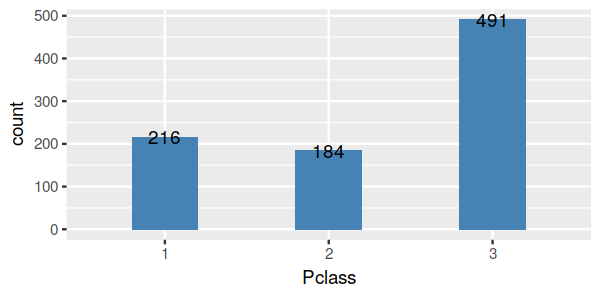

In [21]:
options(repr.plot.width = 5, repr.plot.height = 2.5)
ggplot(trainSet, aes(Pclass)) + 
  geom_bar(width=0.4, fill="steelblue") + 
  geom_text(stat='count', aes(label=..count..), vjust = "center")

We see that the majority of the people have chosen the third class.

Let's pass to the <code>Name</code> and see some values.

In [22]:
unique(trainSet$Name)[1:20]

[1] "Braund, Mr. Owen Harris"                                
 [2] "Cumings, Mrs. John Bradley (Florence Briggs Thayer)"    
 [3] "Heikkinen, Miss. Laina"                                 
 [4] "Futrelle, Mrs. Jacques Heath (Lily May Peel)"           
 [5] "Allen, Mr. William Henry"                               
 [6] "Moran, Mr. James"                                       
 [7] "McCarthy, Mr. Timothy J"                                
 [8] "Palsson, Master. Gosta Leonard"                         
 [9] "Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"      
[10] "Nasser, Mrs. Nicholas (Adele Achem)"                    
[11] "Sandstrom, Miss. Marguerite Rut"                        
[12] "Bonnell, Miss. Elizabeth"                               
[13] "Saundercock, Mr. William Henry"                         
[14] "Andersson, Mr. Anders Johan"                            
[15] "Vestrom, Miss. Hulda Amanda Adolfina"                   
[16] "Hewlett, Mrs. (Mary D Kingcome) "                       
[17] "Rice, Master. Eugene"                                   
[18] "Williams, Mr. Charles Eugene"                           
[19] "Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)"
[20] "Masselmani, Mrs. Fatima"

We see that we have a title associated to each person. Maybe it's an important feature so let's try to extract it.

In [23]:
trainSet$Title <- unlist(lapply(strsplit(trainSet$Name,split=",") ,
                         FUN= function(name) {
                         str_trim(strsplit(name[2],split="\\.")[[1]][1])
                         })
                         )
trainSet$Title  %<>% as.factor 

We add a level that we will see in the predict set but that is not present in the training one.

In [24]:
trainSet$Title <- factor(trainSet$Title, levels = c(levels(trainSet$Title), "Dona"))

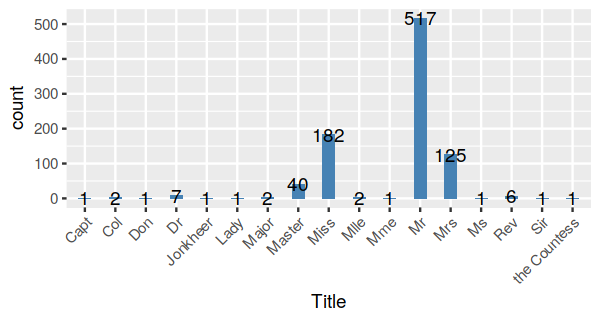

In [25]:
options(repr.plot.width=5, repr.plot.height=2.7)
ggplot(trainSet, aes(Title)) + 
  geom_bar(width=0.4, fill="steelblue") +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
  geom_text(stat='count', aes(label=..count..), vjust = "center")

In [26]:
trainSet %<>% select(-Name) 

Let's move to <code>Sex</code> that we convert in factor.

In [27]:
unique(trainSet$Sex)

[1] "male"   "female"

In [28]:
trainSet$Sex %<>% as.factor

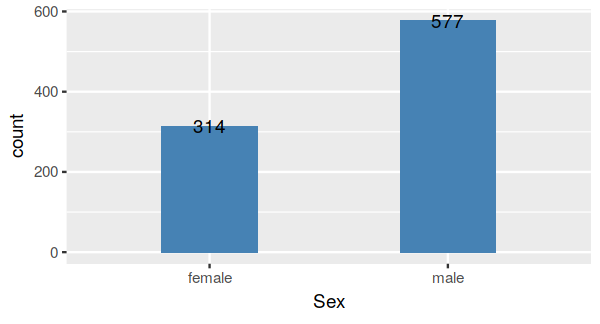

In [29]:
ggplot(trainSet, aes(Sex)) + 
  geom_bar(width=0.4, fill="steelblue") + 
  geom_text(stat='count', aes(label=..count..), vjust = "center")

We see that the number of males is two times the number of females.

Let's pass to the <code>Embarked</code> variable.

Let's convert the <code>Embarked == ""</code> to <code>NA</code>.

In [30]:
trainSet$Embarked[trainSet$Embarked == ""] <- NA

In [31]:
trainSet$Embarked %<>% as.factor

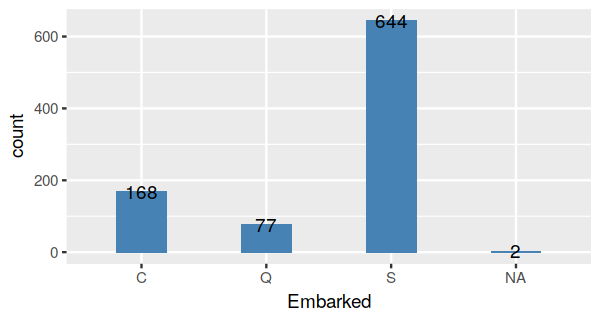

In [32]:
ggplot(trainSet, aes(Embarked)) + 
   geom_bar(width=0.4, fill="steelblue") + 
   geom_text(stat='count', aes(label=..count..), vjust = "center")

We have three possibilies for the ports. We have two cases in which we don't know the embarkation.

In [33]:
unique(trainSet$Embarked)

[1] S    C    Q    <NA>
Levels: C Q S

Let's continue with <code>Ticket</code>.

In [34]:
unique(trainSet$Ticket)[1:20]

[1] "A/5 21171"        "PC 17599"         "STON/O2. 3101282" "113803"          
 [5] "373450"           "330877"           "17463"            "349909"          
 [9] "347742"           "237736"           "PP 9549"          "113783"          
[13] "A/5. 2151"        "347082"           "350406"           "248706"          
[17] "382652"           "244373"           "345763"           "2649"

We see that we have a number with sometimes some letters before. Let's try to extract them.

In [35]:
trainSet$TypeTicket <- map_chr(strsplit(trainSet$Ticket, split = " "), 
                                function(var){
                                    if(length(var) == 2)
                                        return (var[1])
                                    else return("")
                                }
                                )

In [36]:
unique(trainSet$TypeTicket)[1:20]

[1] "A/5"       "PC"        "STON/O2."  ""          "PP"        "A/5."     
 [7] "C.A."      "A./5."     "SC/Paris"  "S.C./A.4." "A/4."      "CA"       
[13] "S.P."      "S.O.C."    "SO/C"      "W./C."     "SOTON/OQ"  "W.E.P."   
[19] "A4."       "C"

We see that sometimes some variables are similar except for some dots and /. Let's try to remove them.

In [37]:
trainSet$TypeTicket <- gsub("\\.", "", trainSet$TypeTicket)
trainSet$TypeTicket <- gsub("/", "", trainSet$TypeTicket )

In [38]:
trainSet$TypeTicket %<>% as.factor 

We add some levels that we will see in the predict set but that are not present in the training one.

In [39]:
trainSet$TypeTicket <- factor(trainSet$TypeTicket, levels = c(levels(trainSet$TypeTicket), 
                                                              "AQ3", 
                                                              "STONOQ",
                                                              "AQ4",
                                                              "LP",
                                                              "SCA3"
                                                               ))

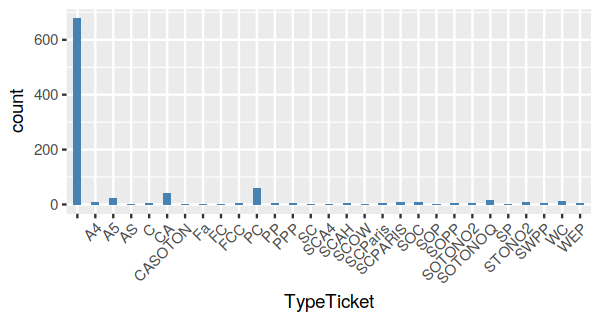

In [40]:
ggplot(trainSet, aes(TypeTicket)) + 
    geom_bar(width=0.4, fill="steelblue") +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) 

We have a lot of tickets without a letter. But maybe when it's present is important. We will see it with the model.

In [41]:
trainSet %<>% select(-Ticket) 

We finish this first analysis seeing the <code>Cabin</code>.

In [42]:
unique(trainSet$Cabin)[1:20]

[1] ""            "C85"         "C123"        "E46"         "G6"         
 [6] "C103"        "D56"         "A6"          "C23 C25 C27" "B78"        
[11] "D33"         "B30"         "C52"         "B28"         "C83"        
[16] "F33"         "F G73"       "E31"         "A5"          "D10 D12"

We see that some people don't have a cabin, some other ones more than one and each cabin has a letter.

Let's create other features related with the **number of cabins** and the **letter associated to it**.

In [43]:
trainSet %<>% mutate(NumberOfCabins = 0, typeOfCabin = NA)

In [44]:
for (i in 1 : nrow(trainSet)){
    cabin <- trainSet$Cabin[i]
    if(cabin != ""){
        num <- strsplit(cabin, split = " ")[[1]]
        trainSet$NumberOfCabins[i] <- length(num)
        if(trainSet$NumberOfCabins[i] == 1){
            trainSet$typeOfCabin[i] <- gsub('[[:digit:]]+', '', num)
        }else if(trainSet$NumberOfCabins[i] > 1){
            numNoDigit <- gsub('[[:digit:]]+', '', num[1])
            trainSet$typeOfCabin[i] <- numNoDigit
        }else{
            trainSet$typeOfCabin[i] <- "NOLETTER"
        }
    }else{
        trainSet$NumberOfCabins[i] <- 0
        trainSet$typeOfCabin[i] <- "NOCABIN"
    }
}


In [45]:
trainSet %<>% select(-Cabin)

In [46]:
trainSet$typeOfCabin %<>% as.factor

Let's see our final dataset.

In [47]:
str(trainSet)

'data.frame':	891 obs. of  12 variables:
 $ Survived      : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass        : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex           : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age           : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp         : num  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch         : num  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare          : num  7,25 71,28 7,92 53,10 8,05 ...
 $ Embarked      : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title         : Factor w/ 18 levels "Capt","Col","Don",..: 12 13 9 13 12 12 12 8 13 13 ...
 $ TypeTicket    : Factor w/ 34 levels "","A4","A5","AS",..: 3 11 26 1 1 1 1 1 1 1 ...
 $ NumberOfCabins: num  0 1 0 1 0 0 1 0 0 0 ...
 $ typeOfCabin   : Factor w/ 9 levels "A","B","C","D",..: 8 3 8 3 8 8 5 8 8 8 ...


Let's see some statistics of our numerical variables.

In [48]:
describe(trainSet)[c(4,5,6,7,11),]

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
Age,4,714,"29,6991176","14,5264973","28,0000","29,2692308","13,34340","0,42","80,0000","79,5800","0,3874744","0,1597671","0,54364050"
SibSp,5,891,"0,5230079","1,1027434","0,0000","0,2720898","0,00000","0,00","8,0000","8,0000","3,6829188","17,7269083","0,03694329"
Parch,6,891,"0,3815937","0,8060572","0,0000","0,1823282","0,00000","0,00","6,0000","6,0000","2,7398677","9,6880847","0,02700393"
Fare,7,891,"32,2042080","49,6934286","14,4542","21,3787156","10,23617","0,00","512,3292","512,3292","4,7712097","33,1230682","1,66479250"
NumberOfCabins,11,891,"0,2671156","0,5471340","0,0000","0,1612903","0,00000","0,00","4,0000","4,0000","2,5183751","8,5563377","0,01832968"


Let's finally see the number of <code>NA</code> for each feature.

In [49]:
colSums(is.na(trainSet))

Survived         Pclass            Sex            Age          SibSp 
             0              0              0            177              0 
         Parch           Fare       Embarked          Title     TypeTicket 
             0              0              2              0              0 
NumberOfCabins    typeOfCabin 
             0              0

So we have to **fill** the <code>Age</code> and <code>Embarked</code> variables where we have <code>NA</code> values.

We will do it in another section.

### 1.1.2 Exploration of the relationship between the variables

Let's continue studying the relationship between the variables with some visual data exploration.

Let's see the number of male and female that survived.

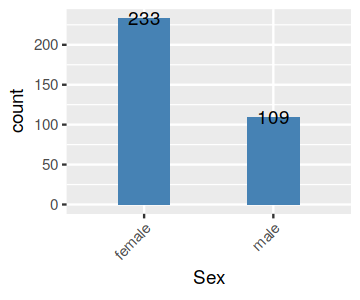

In [50]:
options(repr.plot.width=3, repr.plot.height = 2.5)
ggplot(trainSet[trainSet$Survived == 1, ],  aes(Sex)) + 
    geom_bar(width=0.4, fill="steelblue") +
    theme(axis.text.x = element_text(angle = 45, hjust=1))+ 
    geom_text(stat='count', aes(label=..count..), vjust = "center")

We have a prevalence of female survived despite of the fact we have more male than female in the sample. 

Maybe the reason is that we usually save women, aged and children first. But these two last ones are less likely to survive.

Let's see if there is a difference of <code>Age</code> between who survived.

In [51]:
options(repr.plot.width = 6, repr.plot.height = 2.5)

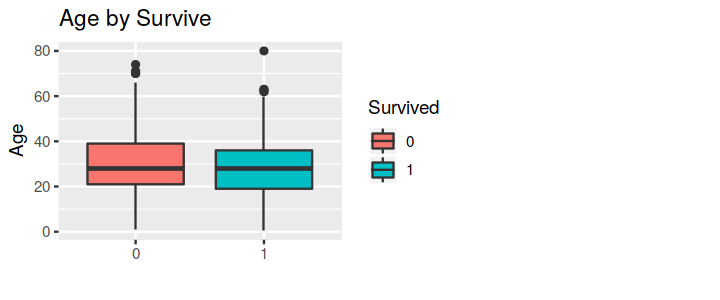

In [52]:
qplot(Survived, Age, data = trainSet[!is.na(trainSet$Age),], geom = c("boxplot"),
      fill = Survived,
      main = "Age by Survive",
      xlab = "", ylab = "Age")

The results seem the same. We don't see big differences at this granularity.

Let's analyze if there is a diffence of age depending on the <code>Pclass</code>.

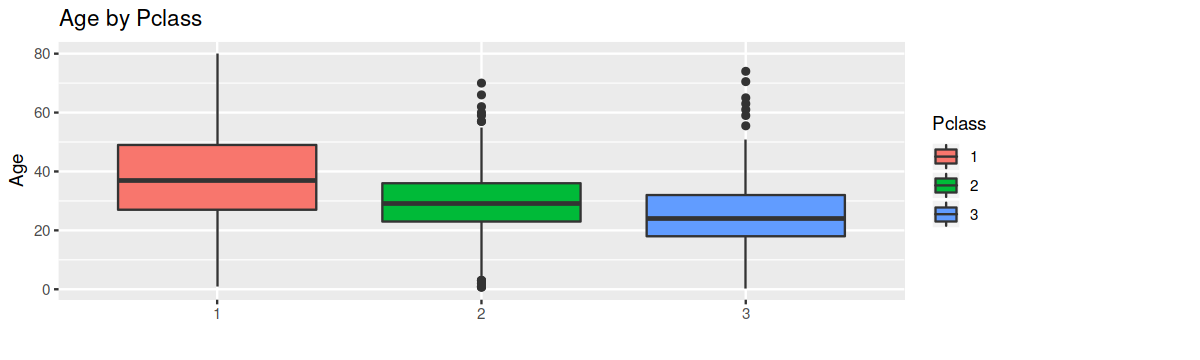

In [53]:
options(repr.plot.width=10, repr.plot.height=3)
qplot(Pclass, Age, data = trainSet[!is.na(trainSet$Age),], geom=c("boxplot"),
      fill=Pclass, main="Age by Pclass",
      xlab="", ylab="Age")

We see a difference of <code>Age</code> related with the <code>Pclass</code>. 

It makes sense because older people have more money than young ones.

Let's see if <code>Pclass</code> is related with the survival.

In [54]:
surv <- trainSet[trainSet$Survived == 1, ]

In [55]:
tableSurv <- table(surv$Pclass)/table(trainSet$Pclass)
percent <- tibble(Pclass = names(tableSurv),
                  Percent = unname(table(surv$Pclass)/table(trainSet$Pclass))  %>% 
                  as.numeric)

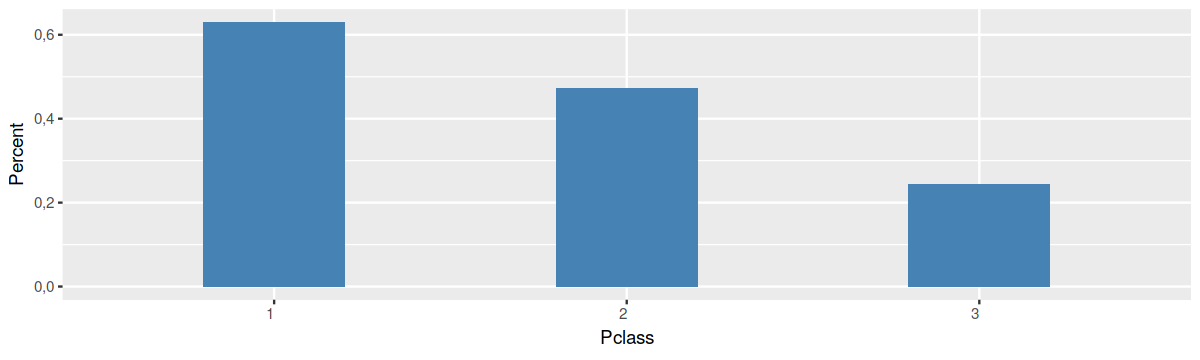

In [56]:
ggplot(percent,  aes(x = Pclass, y = Percent)) + 
  geom_bar(stat="identity", width=0.4, fill="steelblue") +
  theme(axis.text.x = element_text(angle = 0, hjust=1)) 

It's clear that the higher is the <code>Pclass</code>, the more we are likely to survive. Maybe the lifeboats are nearer the first class.

Let's see if the title can change the probability to survive.

In [57]:
table(surv$Title)


        Capt          Col          Don           Dr     Jonkheer         Lady 
           0            1            0            3            0            1 
       Major       Master         Miss         Mlle          Mme           Mr 
           1           23          127            2            1           81 
         Mrs           Ms          Rev          Sir the Countess         Dona 
          99            1            0            1            1            0 

In [58]:
table(trainSet$Title)


        Capt          Col          Don           Dr     Jonkheer         Lady 
           1            2            1            7            1            1 
       Major       Master         Miss         Mlle          Mme           Mr 
           2           40          182            2            1          517 
         Mrs           Ms          Rev          Sir the Countess         Dona 
         125            1            6            1            1            0 

In [59]:
tableSurv <- table(surv$Title)/table(trainSet$Title)
percent <- tibble(Title = names(tableSurv), 
                  Percent = unname(table(surv$Title)/table(trainSet$Title))  %>%
                  as.numeric)

Warning message:
“Removed 1 rows containing missing values (position_stack).”

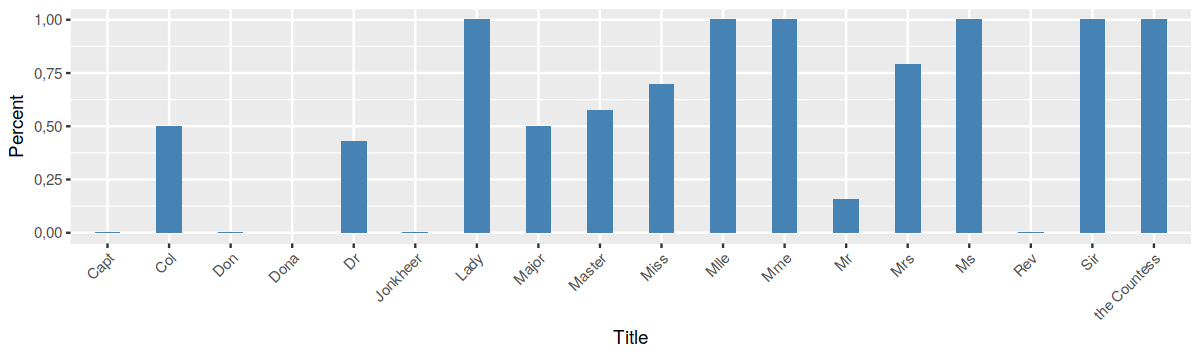

In [60]:
ggplot(percent,  aes(x = Title, y = Percent)) + 
  geom_bar(stat="identity", width=0.4, fill="steelblue") +
  theme(axis.text.x = element_text(angle = 45, hjust=1))

We see that some <code>Titles</code> are more likely to survive that other ones.

Let's see the distribution of the age according to the <code>Sex</code> and <code>Pclass</code>.

This could be useful to fill the <code>NA</code> values. In fact usually it's not the best strategy to fill with the mean/median value. 

The reasons are two:

1. We would change the distribution of the data, projecting them around the mean/median.
2. Introducing a constant number despite of the variability of the other features we can decorrelate them.
    
The best thing to do can be to replace with a mean/median value related with other variables, so according to a class.

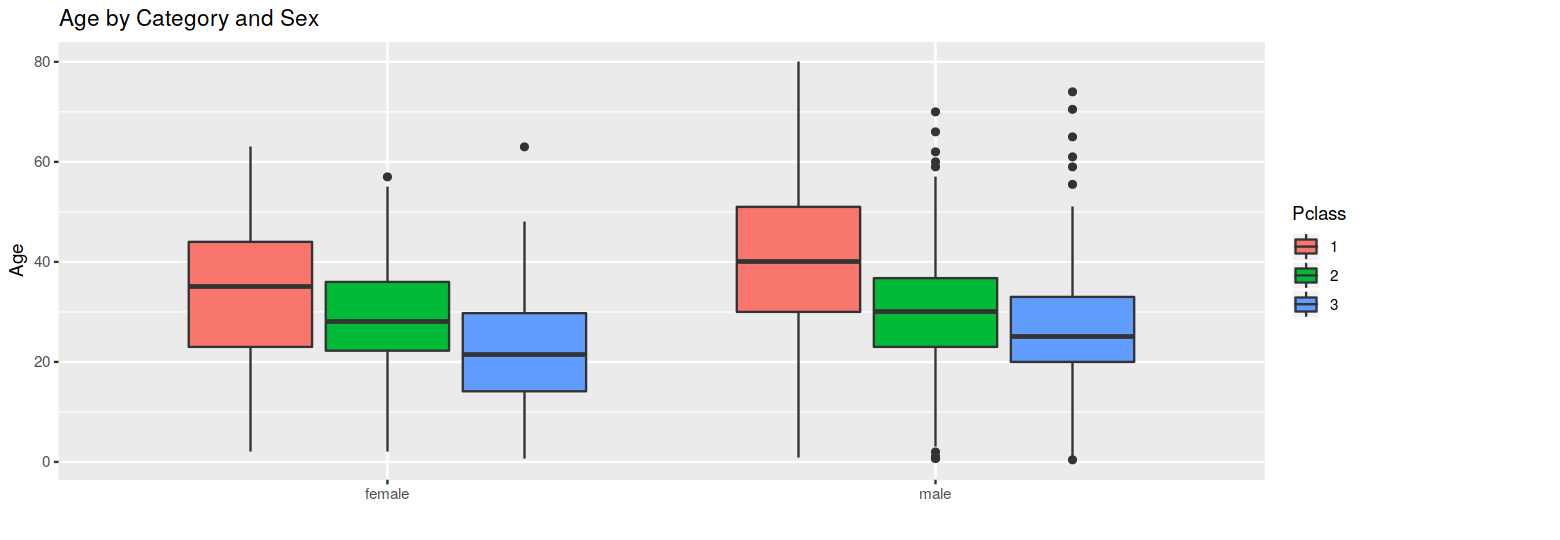

In [61]:
options(repr.plot.width=13, repr.plot.height=4.5)
qplot(Sex, Age, data = trainSet[!is.na(trainSet$Age),], geom=c("boxplot"),
      fill=Pclass, main="Age by Category and Sex",
      xlab="", ylab="Age")

In this case we see that these variables have a strong relationship. We see in particular that the first class is also different for the <code>Sex</code>.

Let's now see the <code>Embarked</code> variable.

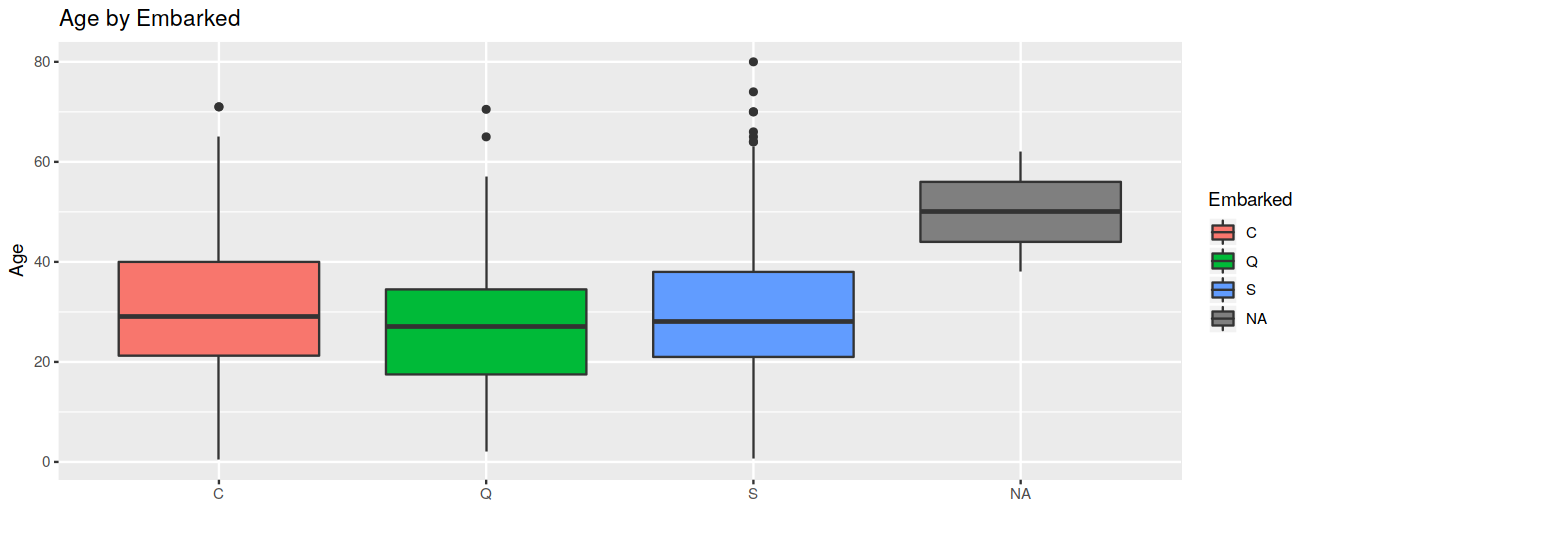

In [62]:
qplot(Embarked, Age, data = trainSet[!is.na(trainSet$Age),], geom = c("boxplot"),
        fill = Embarked, main = "Age by Embarked",
        xlab="", ylab="Age")

We don't see big differences among the known embarked ports. So it's not interesting for filling the <code>Age</code>.

In [63]:
tmp <- trainSet[!is.na(trainSet$Age),]
tmp$Parch %<>% as.factor
tmp$SibSp %<>% as.factor 

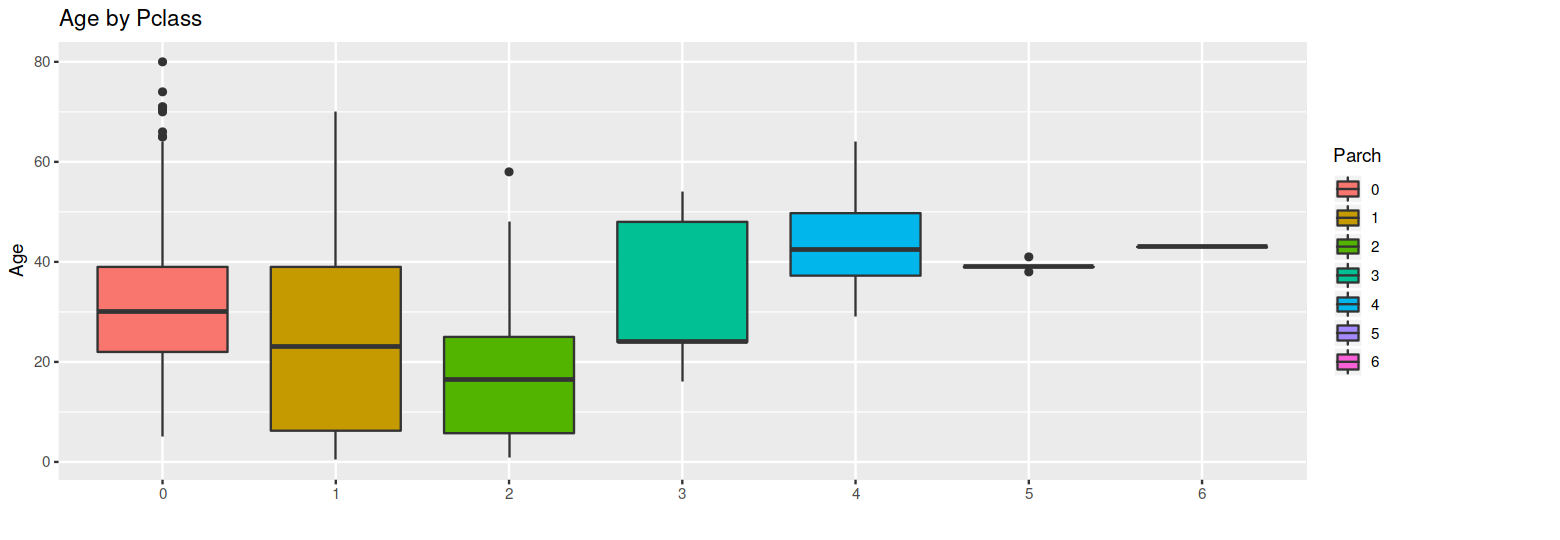

In [64]:
qplot(Parch, Age, data = tmp, geom=c("boxplot"),
      fill= Parch, main="Age by Pclass",
      xlab="", ylab="Age")

We can interpret that the more we have children the older we are. 

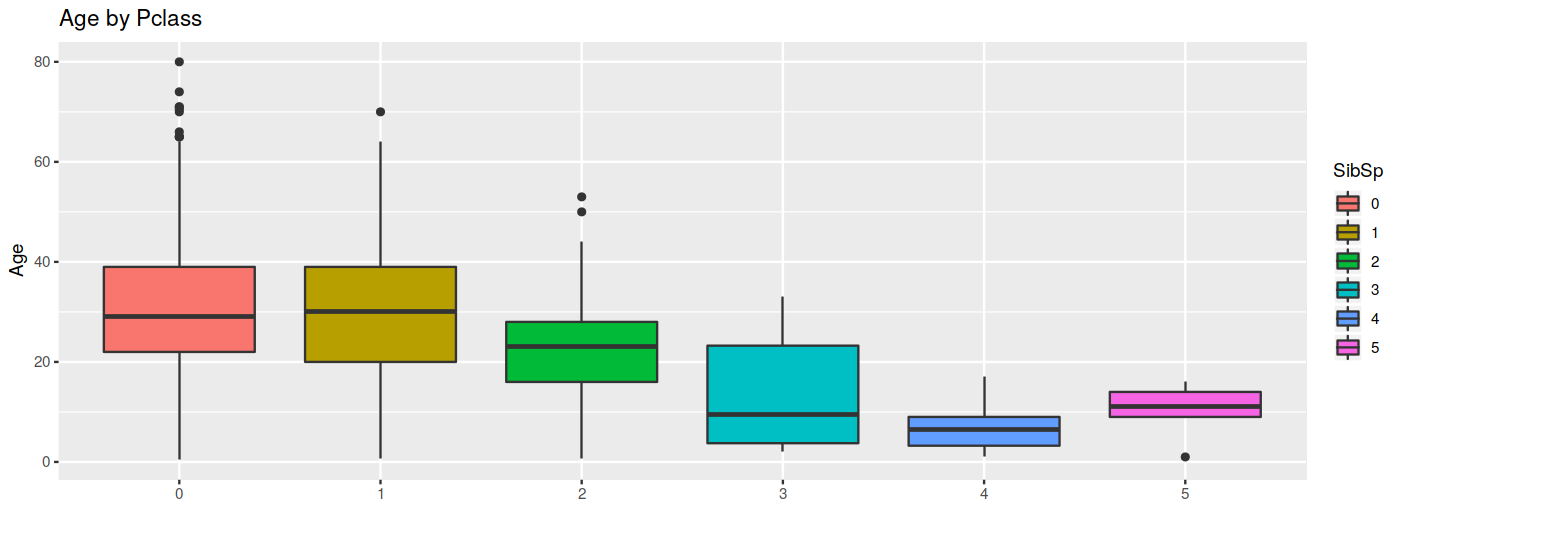

In [65]:
qplot(SibSp, Age, data = tmp, geom=c("boxplot"),
      fill = SibSp, main="Age by Pclass",
      xlab="", ylab="Age")

In that case if we have a lot of brother and syster on bord we are in a family and we are young.

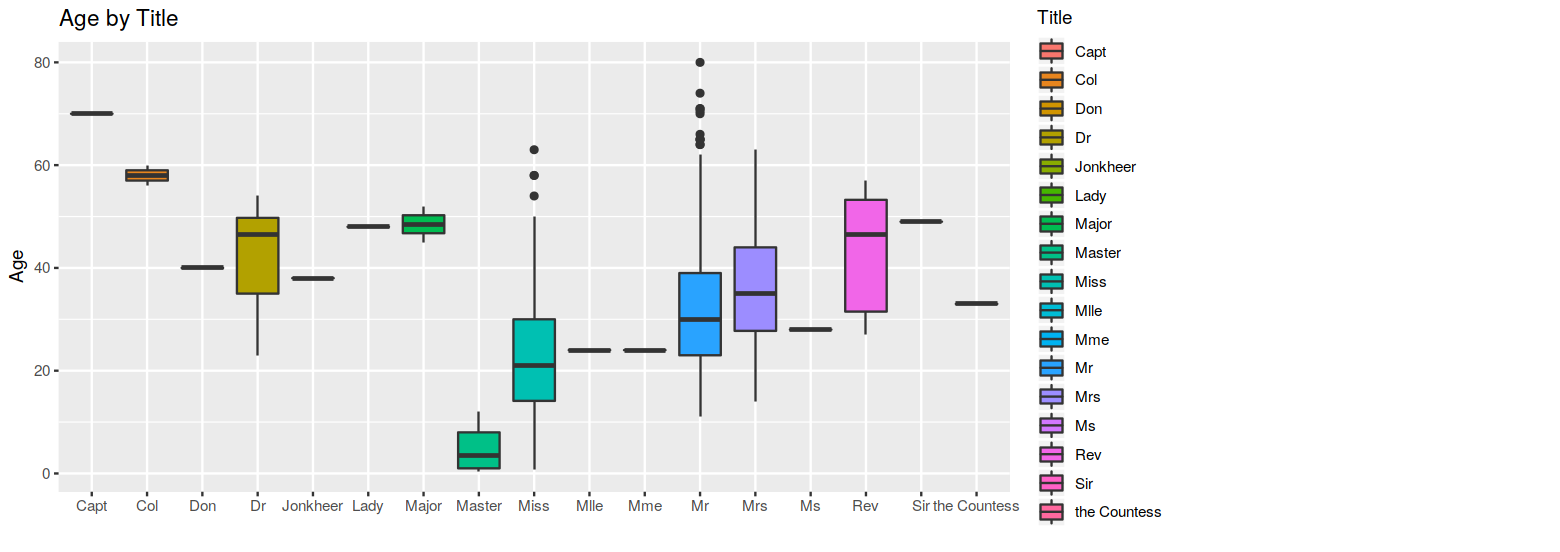

In [66]:
options(repr.plot.width=13, repr.plot.height=4.6)
qplot(Title, Age, data = tmp, geom=c("boxplot"),
      fill = Title,
      main="Age by Title",
      xlab="", ylab="Age")

The situation here depends on the title.

## 1.3 Filling NA values

In this part we will fill the <code>NA</code> studying the two techniques we have introduced before.

In particular we will follow this strategy:

1. To use total mean/median.
2. To use mean/median according to a class.

In the second case we will use <code>Sex</code> and <code>Pclass</code> to fill the <code>NA</code> for the <code>Age</code>.

The <code>Parch</code>, the <code>SibSp</code> and the <code>Title</code> are not good variables for filling because we have not a good sample. Sometimes we only have few samples of each possibility.

Let's first split into learning and test set. We will fill the learning and use the same value for the test.

In [67]:
set.seed(786)
partition <- createDataPartition(trainSet$Survived, p = 0.8, list = FALSE)

In [68]:
learningSet <- trainSet[partition, ]
testSet <- trainSet[-partition, ]

In [69]:
trainGrouped <- learningSet %>% group_by(Sex, Pclass)
summarise(trainGrouped,
          meanAge = mean(Age, na.rm = TRUE) , 
          meadianAge = median(Age, na.rm = TRUE),
          numberOfNA = sum(is.na(Age)))

`summarise()` regrouping output by 'Sex' (override with `.groups` argument)


Sex,Pclass,meanAge,meadianAge,numberOfNA
female,1,"36,39394","35,5",9
female,2,"29,33621","29,0",1
female,3,"20,38415","21,0",33
male,1,"40,62707","41,0",17
male,2,"31,19440","30,0",8
male,3,"26,63819","25,0",75


Let's see the distribution of the data before the filling.

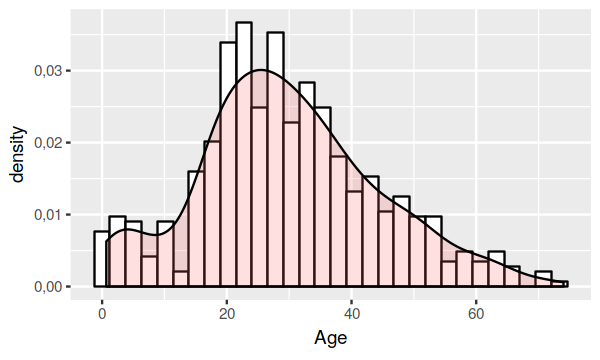

In [70]:
options(repr.plot.width=5, repr.plot.height=3)
ggplot(learningSet[!is.na(learningSet$Age),], aes(x=Age)) + 
   geom_histogram(aes(y=..density..), colour="black", fill="white", bins = 30)+
   geom_density(alpha=.2, fill="#FF6666") 

If we fill with the mean/median we obtain:

In [71]:
tmp <- learningSet
tmp$Age[is.na(tmp$Age)] <- median(tmp$Age, na.rm = TRUE)

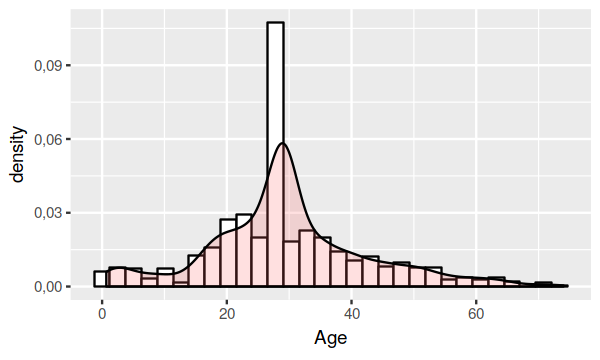

In [72]:
ggplot(tmp, aes(x=Age)) + 
   geom_histogram(aes(y=..density..), colour="black", fill="white", bins = 30)+
   geom_density(alpha=.2, fill="#FF6666") 

And we have projected the distribution of our data around the median.

Doing it by group:

In [73]:
meanByGroup <- summarise(trainGrouped,
                          meadianAge = median(Age, na.rm = TRUE),
                          )

`summarise()` regrouping output by 'Sex' (override with `.groups` argument)


In [74]:
meanByGroup

Sex,Pclass,meadianAge
female,1,"35,5"
female,2,"29,0"
female,3,"21,0"
male,1,"41,0"
male,2,"30,0"
male,3,"25,0"


In [75]:
meanByGroup$meadianAge[meanByGroup$Sex == "female" & meanByGroup$Pclass == "1"]

[1] 35,5

In [76]:
learningSetFilled <- learningSet
learningSetFilled$Age[is.na(learningSetFilled$Age) & 
                      learningSetFilled$Sex == "female" &
                      learningSetFilled$Pclass=="1"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" &
                                                                               meanByGroup$Pclass == "1"]

learningSetFilled$Age[is.na(learningSetFilled$Age) &
                      learningSetFilled$Sex == "female" & 
                      learningSetFilled$Pclass=="2"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" &
                                                                               meanByGroup$Pclass == "2"]

learningSetFilled$Age[is.na(learningSetFilled$Age) &
                      learningSetFilled$Sex == "female" &
                      learningSetFilled$Pclass=="3"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" &
                                                                               meanByGroup$Pclass == "3"]

learningSetFilled$Age[is.na(learningSetFilled$Age) & 
                      learningSetFilled$Sex == "male" & 
                      learningSetFilled$Pclass=="1"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" & 
                                                                               meanByGroup$Pclass == "1"]

learningSetFilled$Age[is.na(learningSetFilled$Age) &
                      learningSetFilled$Sex == "male" &
                      learningSetFilled$Pclass=="2"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                               meanByGroup$Pclass == "2"]

learningSetFilled$Age[is.na(learningSetFilled$Age) &
                      learningSetFilled$Sex == "male" & 
                      learningSetFilled$Pclass=="3"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                               meanByGroup$Pclass == "3"]

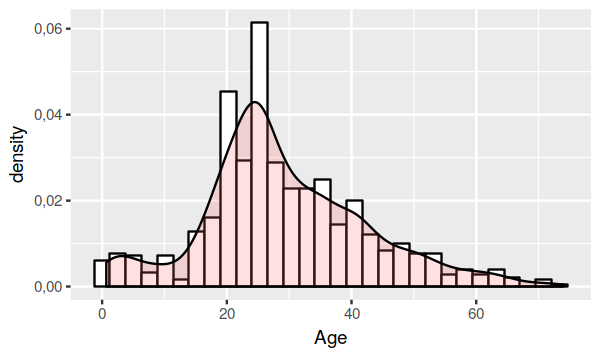

In [77]:
ggplot(learningSetFilled, aes(x=Age)) + 
   geom_histogram(aes(y=..density..), colour="black", fill="white", bins = 30)+
   geom_density(alpha=.2, fill="#FF6666") 

We have seen the difference of the distributions with the graphs but let's see it from a numerical point of view.

What we expect is that the first filling method gives better results for the general statistics because we are not changing the overall distribution but we only add a costant value. On the other side with the other method we are changing more values. But we expect that the second method has more variability because we are trying to replicate the dispersion of the original distribution.

**ORIGINAL**

In [78]:
describe(learningSet$Age)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,571,"29,82093","14,49773",29,"29,49781","13,3434","0,67",74,"73,33","0,2958834","-0,02746656","0,6067111"


**GENERAL MEDIAN**

In [79]:
describe(tmp$Age)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,714,"29,65651","12,96679",29,"29,27972","9,6369","0,67",74,"73,33","0,368658","0,7325377","0,4852698"


**MEDIAN BY CLASS**

In [80]:
describe(learningSetFilled$Age)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,714,"29,24545","13,30909",26,"28,76661","10,3782","0,67",74,"73,33","0,4321121","0,4336477","0,4980802"


We see what we have predicted before. 

In this case the best choice of the filling method depends on our goal. 
To finish our analysis let's see **how much the correlation between numerical values changes changing the filling method**.

In [81]:
crAF <- cor(learningSet[!is.na(learningSet$Age),c("Fare", "Age", "SibSp", "Parch")])
crAF

,Fare,Age,SibSp,Parch
Fare,"1,0000000","0,1200037","0,1674889","0,2147491"
Age,"0,1200037","1,0000000","-0,3106454","-0,2132586"
SibSp,"0,1674889","-0,3106454","1,0000000","0,3905971"
Parch,"0,2147491","-0,2132586","0,3905971","1,0000000"


In [82]:
crAFC <- cor(learningSetFilled  %>% select(Fare, Age, SibSp, Parch))
crAFC

,Fare,Age,SibSp,Parch
Fare,"1,0000000","0,1491561","0,1888091","0,2203467"
Age,"0,1491561","1,0000000","-0,2474218","-0,2004936"
SibSp,"0,1888091","-0,2474218","1,0000000","0,4255458"
Parch,"0,2203467","-0,2004936","0,4255458","1,0000000"


In [83]:
(crAFC/crAF)[2,]

Fare       Age     SibSp     Parch 
1,2429288 1,0000000 0,7964765 0,9401432

In [84]:
crAFM <- cor(tmp %>% select(Fare, Age, SibSp, Parch) )

In [85]:
(crAFM/crAF)[2,]

Fare       Age     SibSp     Parch 
0,9492351 1,0000000 0,7317020 0,9262243

In reality we don't see big differences. 

We could try to see if this influence the results using both methods in the learning process.

In [86]:
sum(is.na(learningSet$Age))/nrow(learningSet)

[1] 0,2002801

We can also see that most of the data are present and we are only filling one variable. In this case using one or another technique seems not changing too much the results.

In [87]:
colSums(is.na(learningSetFilled))

Survived         Pclass            Sex            Age          SibSp 
             0              0              0              0              0 
         Parch           Fare       Embarked          Title     TypeTicket 
             0              0              2              0              0 
NumberOfCabins    typeOfCabin 
             0              0

In this case we don't have <code>NA</code> in the <code>Age</code> anymore, as expected.

Let's analyze the <code>Embarked</code> variable with respect to the <code>Fare</code> and <code>Pclass</code>.

What is the reason? The fact is that if we know the class ticket and the fare associated we problably know where we bought the ticket too.

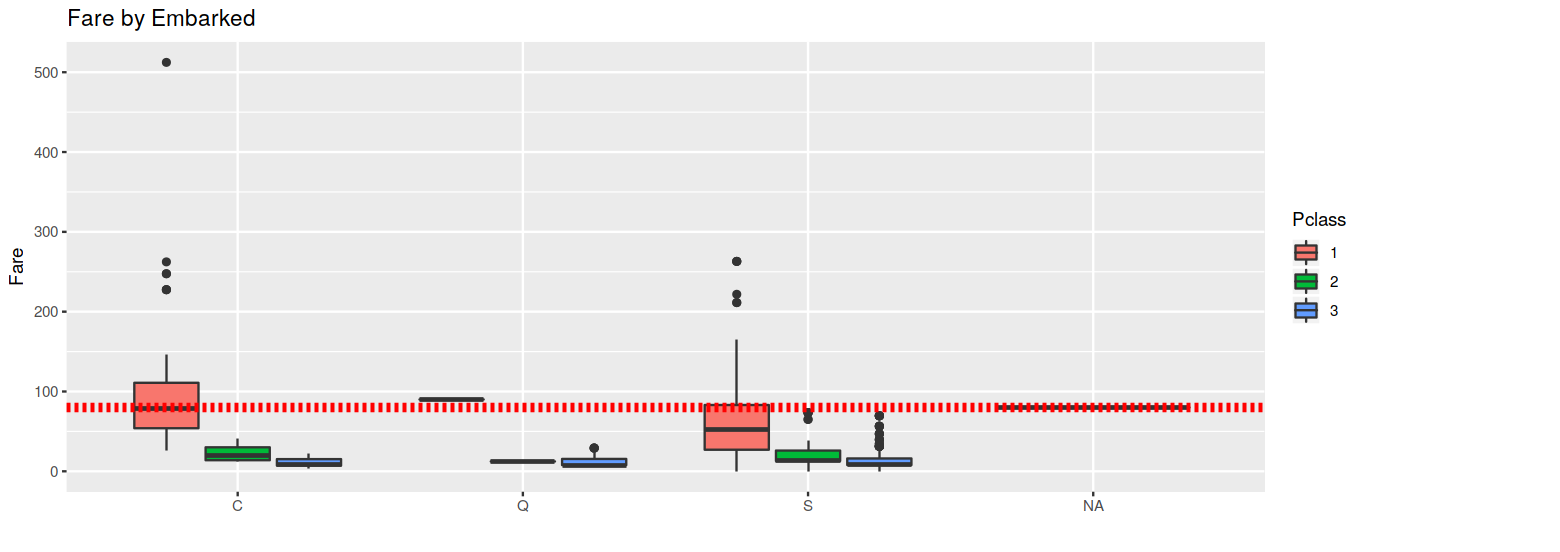

In [88]:
options(repr.plot.width=13, repr.plot.height=4.6)
qplot(Embarked, Fare, data = learningSetFilled, geom=c("boxplot"),
      fill = Pclass,
      main="Fare by Embarked",
      xlab="", ylab="Fare")+ 
      geom_hline(aes(yintercept=median(learningSetFilled$Fare[is.na(learningSetFilled$Embarked)])), 
      colour='red', linetype='dashed', lwd=2) 

So we can fill with the <code>C</code> port. 

In [90]:
learningSetFilled$Embarked[is.na(learningSetFilled$Embarked)] <- "C"

## 1.4 Modeling and Error Analysis

In this part we will try different methods and we will compare them with different metrics and analysis.

We will try four different models:

- Logistic Regressor
- KNN
- Classification tree
- Random forest


From an operational point of view we will:
1. Preprocess the data.
2. Decide the validation approach
3. Compare models.
4. Predict new values

In [91]:
str(learningSetFilled)

'data.frame':	714 obs. of  12 variables:
 $ Survived      : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 2 2 2 ...
 $ Pclass        : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 2 3 ...
 $ Sex           : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 1 1 1 ...
 $ Age           : num  22 38 26 35 35 25 54 27 14 4 ...
 $ SibSp         : num  1 1 0 1 0 0 0 0 1 1 ...
 $ Parch         : num  0 0 0 0 0 0 0 2 0 1 ...
 $ Fare          : num  7,25 71,28 7,92 53,10 8,05 ...
 $ Embarked      : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 1 3 ...
 $ Title         : Factor w/ 18 levels "Capt","Col","Don",..: 12 13 9 13 12 12 12 13 13 9 ...
 $ TypeTicket    : Factor w/ 34 levels "","A4","A5","AS",..: 3 11 26 1 1 1 1 1 1 12 ...
 $ NumberOfCabins: num  0 1 0 1 0 0 1 0 0 1 ...
 $ typeOfCabin   : Factor w/ 9 levels "A","B","C","D",..: 8 3 8 3 8 8 5 8 8 7 ...


We rename the factor levels otherwise we have some problems with the models.

In [92]:
learningSetFilled$Survived <- plyr::revalue(learningSetFilled$Survived,
                                            c("0"="Not_survived", "1"="Survived")
                                           )
learningSetFilled$Pclass <- plyr::revalue(learningSetFilled$Pclass,
                                          c("1"="first_class", "2"="second_class", "3" = "third_class")
                                         )
testSet$Survived <- plyr::revalue(testSet$Survived,
                                  c("0"="Not_survived", "1"="Survived")
                                  )
testSet$Pclass <- plyr::revalue(testSet$Pclass,
                                c("1"="first_class", "2"="second_class", "3" = "third_class")
                                )

### 1.4.1 Pre-processing the data

In general we have three techniques to apply for the pre-processing of the data:
- Remove <code>NA</code> values.
- Remove skewness.
- Center and scale.

We have already done the first thing. So let's move on the other ones.

We will remove the skewness from the skewed variables with a [Box-Cox transformation](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203).

Let's see the skewness for some of the numerical variables.

In [93]:
apply(learningSetFilled  %>% select(Age, Fare, SibSp, Parch ), 2, e1071::skewness)

Age      Fare     SibSp     Parch 
0,4321121 4,1261874 3,7155138 2,5408927

As we have seen in the EDA, <code>Age</code> is pretty normal distributed so we don't need big transformations on it.

We will add a 1 to <code>Fare</code>, <code>SibSp</code> and <code>Parch</code> because otherwise the Box-Cox transformation has to deal with non possible values (0 values).

In [94]:
learningSetFilled$Fare <- learningSetFilled$Fare + 1
learningSetFilled$SibSp <- learningSetFilled$SibSp + 1
learningSetFilled$Parch <- learningSetFilled$Parch + 1

We will also scale and center our data, very important procedure for <code>KNN</code> and <code>logistic regression</code>.

In [95]:
trans <- preProcess(learningSetFilled, method = c("BoxCox", "center", "scale"))

In [96]:
trans

Created from 714 samples and 12 variables

Pre-processing:
  - Box-Cox transformation (4)
  - centered (5)
  - ignored (7)
  - scaled (5)

Lambda estimates for Box-Cox transformation:
0,8, -2, -2, -0,1

Before the transformation we have:

In [97]:
describe(learningSetFilled)[c(4,5,6,7,11),]

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
Age,4,714,"29,2454482","13,3090903","26,0","28,7666084","10,37820","0,67","74,0000","73,3300","0,4321121","0,4336477","0,49808019"
SibSp,5,714,"1,5476190","1,1536155","1,0","1,2867133","0,00000","1,00","9,0000","8,0000","3,7155138","17,5429061","0,04317298"
Parch,6,714,"1,3837535","0,7969538","1,0","1,1905594","0,00000","1,00","6,0000","5,0000","2,5408927","7,8906134","0,02982525"
Fare,7,714,"32,5526598","44,1443086","15,5","23,0157837","10,38443","1,00","513,3292","512,3292","4,1261874","26,7502693","1,65205923"
NumberOfCabins,11,714,"0,2717087","0,5365838","0,0","0,1713287","0,00000","0,00","4,0000","4,0000","2,2875907","6,8820955","0,02008114"


In [98]:
learnSetPrep <- predict(trans, learningSetFilled)

After the transformation:

In [99]:
describe(learnSetPrep)[c(4,5,6,7,11),]

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
Age,4,714,"3,492369e-17",1,"-0,2438520","-0,03597840","0,7797828","-2,1470625","3,362706","5,509768","0,4321121","0,4336477","0,03742406"
SibSp,5,714,"-5,551115e-17",1,"-0,6944569","-0,12470973","0,0000000","-0,6944569","1,922388","2,616845","0,7794549","-1,3078131","0,03742406"
Parch,6,714,"-8,900692e-17",1,"-0,5576429","-0,17886603","0,0000000","-0,5576429","2,204875","2,762518","1,2578508","-0,3560722","0,03742406"
Fare,7,714,"1,802600e-17",1,"-0,2431016","-0,07621021","0,8745181","-3,1002709","3,405529","6,505800","0,2965679","0,7866349","0,03742406"
NumberOfCabins,11,714,"4,360269e-17",1,"-0,5063677","-0,18707238","0,0000000","-0,5063677","6,948199","7,454567","2,2875907","6,8820955","0,03742406"


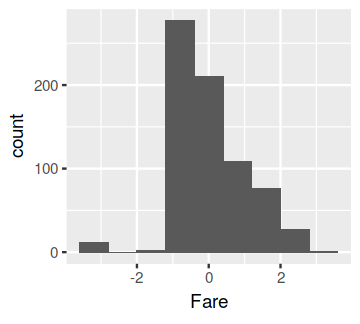

In [100]:
options(repr.plot.width=3, repr.plot.height=2.7)
learnSetPrep %>% 
  ggplot(mapping = aes(x = Fare)) +
  geom_histogram(binwidth = 0.8)

<code>Fare</code> is much more normal distributed that before.

Let's apply all this techniques to the test set.

In [101]:
colSums(is.na(testSet))

Survived         Pclass            Sex            Age          SibSp 
             0              0              0             34              0 
         Parch           Fare       Embarked          Title     TypeTicket 
             0              0              0              0              0 
NumberOfCabins    typeOfCabin 
             0              0

In [102]:
testSetFilled <- testSet
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "female" &
                  testSetFilled$Pclass=="first_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" & 
                                                                       meanByGroup$Pclass == "1"]
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "female" &
                  testSetFilled$Pclass=="second_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" & 
                                                                       meanByGroup$Pclass == "2"]
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "female" &
                  testSetFilled$Pclass=="third_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" &
                                                                       meanByGroup$Pclass == "3"]
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "male" &
                  testSetFilled$Pclass=="first_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "1"]
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "male" & 
                  testSetFilled$Pclass=="second_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "2"]
testSetFilled$Age[is.na(testSetFilled$Age) &
                  testSetFilled$Sex == "male" &
                  testSetFilled$Pclass=="third_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "3"]

In [103]:
testSetFilled$Fare <- testSetFilled$Fare + 1
testSetFilled$SibSp <- testSetFilled$SibSp + 1
testSetFilled$Parch <- testSetFilled$Parch + 1

In [104]:
testSetPrep <- predict(trans, testSetFilled)

In [105]:
describe(testSetPrep)[c(4,5,6,7,11),]

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
Age,4,177,"-0,04755440","1,0138737","-0,3189886","-0,1237910","0,6683853","-2,1658466","3,813525","5,979372","0,9014363","1,5702446","0,07620742"
SibSp,5,177,"-0,11736349","0,9552985","-0,6944569","-0,2636724","0,0000000","-0,6944569","1,881500","2,575957","1,0689026","-0,7836471","0,07180463"
Parch,6,177,"-0,01416243","0,9830507","-0,5576429","-0,1850755","0,0000000","-0,5576429","2,225816","2,783459","1,2683817","-0,3201067","0,07389062"
Fare,7,177,"-0,06191055","1,0516884","-0,3492042","-0,1860083","0,7300811","-3,1002709","3,405529","6,505800","0,7404489","1,5363994","0,07904974"
NumberOfCabins,11,177,"-0,04308947","1,0977214","-0,5063677","-0,2717834","0,0000000","-0,5063677","6,948199","7,454567","3,1998734","13,0331522","0,08250979"


### 1.4.2 Select a validation method

In this part we have to select a validation approach.

Since we don't have a lof of data we cannot use too much data for the dev set. So the best validation is the 10-folds cross validation.

So we will use 642 samples (90%) for the training and 71 samples (10%) for the validation for each splitting. But this would result in an unstable evaluation of the test error. 
So we will use a **5-repeated 10-folds cross validation**.

In [106]:
0.9 * nrow(learningSetFilled)

[1] 642,6

In [107]:
0.1 * nrow(learningSetFilled)

[1] 71,4

In [108]:
ctrl <- trainControl(method = "repeatedcv", 
                     number = 10,
                     repeats = 5,
                     classProbs = TRUE,
                     savePred = TRUE
                     )

For all the error analysis we will use all the data in a cross validation fold because otherwise our set is not statistically significant.

### 1.4.3 Modeling

Let' start with the modeling part.

We will run 5 CPU in parallel.

The metric to evaluate the model will be the <code>Accuracy</code> because we are dealing with a balanced problem.

In [109]:
metric <- "Accuracy"

We begin with a logistic regression.

In [110]:
set.seed(101)
registerDoMC(cores = 5)
lr <- train(Survived ~ ., 
            data = learningSetFilled,
            method = "glm",
            family = "binomial",
            metric = metric,
            trControl = ctrl)

In [111]:
lr

Generalized Linear Model 

714 samples
 11 predictor
  2 classes: 'Not_survived', 'Survived' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 642, 643, 642, 643, 643, ... 
Resampling results:

  Accuracy   Kappa    
  0,8219249  0,6234448


Now we use a KNN.

In [112]:
set.seed(101)
registerDoMC(cores = 5)
knn <- train(Survived ~ ., 
             data = learningSetFilled,
             method = "knn",
             trControl = ctrl,
             metric = metric,
             tuneLength = 10)

In [113]:
knn

k-Nearest Neighbors 

714 samples
 11 predictor
  2 classes: 'Not_survived', 'Survived' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 642, 643, 642, 643, 643, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0,7207199  0,3950487
   7  0,7246792  0,4018941
   9  0,7106690  0,3694272
  11  0,7210211  0,3900633
  13  0,7176408  0,3792797
  15  0,7195892  0,3813170
  17  0,7198748  0,3780985
  19  0,7156651  0,3654052
  21  0,7148474  0,3604920
  23  0,7207042  0,3705007

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.

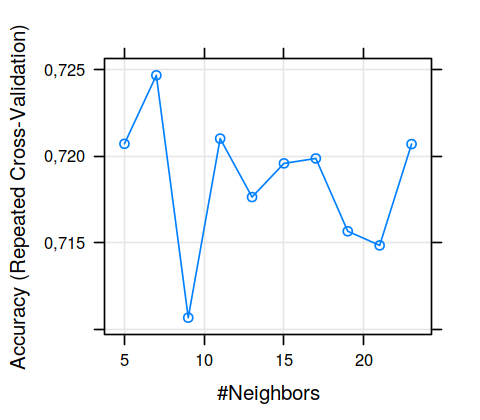

In [114]:
options(repr.plot.width=4, repr.plot.height=3.5)
plot(knn)

Now we use a claffication tree.

In [115]:
set.seed(101)
registerDoMC(cores = 5)
classTree <- train(Survived ~ ., 
             data = learningSetFilled,
             method = "rpart",
             trControl = ctrl,
             metric = metric,
             tuneLength = 10)

In [116]:
classTree

CART 

714 samples
 11 predictor
  2 classes: 'Not_survived', 'Survived' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 642, 643, 642, 643, 643, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa    
  0,00000000  0,8213419  0,6151662
  0,04906732  0,7983568  0,5736154
  0,09813463  0,7823905  0,5463989
  0,14720195  0,7823905  0,5463989
  0,19626926  0,7823905  0,5463989
  0,24533658  0,7823905  0,5463989
  0,29440389  0,7823905  0,5463989
  0,34347121  0,7823905  0,5463989
  0,39253852  0,7823905  0,5463989
  0,44160584  0,6873631  0,2516558

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.

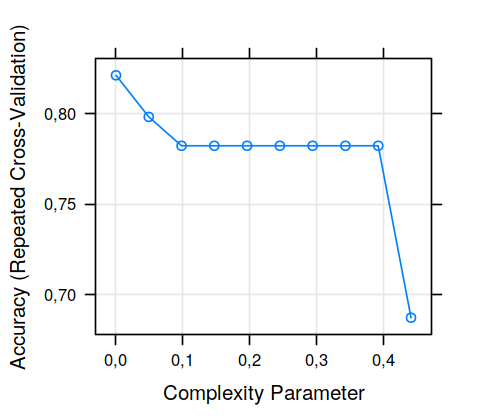

In [117]:
plot(classTree)

We can also see the different splits of the best classification tree.

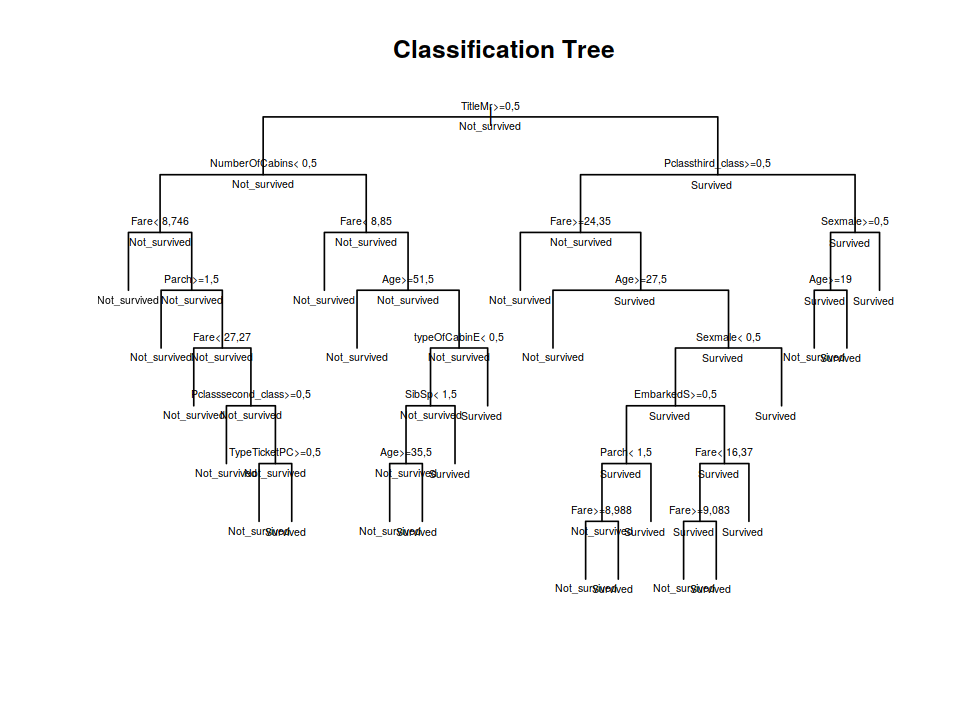

In [117]:
options(repr.plot.width=8, repr.plot.height=6)
plot(classTree$finalModel, uniform=TRUE,
     main="Classification Tree")
text(classTree$finalModel, all=TRUE, cex=.5)


Finally we use a random forest.

In [ ]:
set.seed(101)
registerDoMC(cores = 5)
rf <- train(Survived ~ ., 
            data = learningSetFilled,
            method= 'rf', 
            trControl = ctrl,
            metric = metric,
            tuneLength = 20)

In [119]:
rf

Random Forest 

714 samples
 11 predictor
  2 classes: 'Not_survived', 'Survived' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 642, 642, 643, 642, 643, 643, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0,7509977  0,4061674
   5    0,8171205  0,6086735
   8    0,8283138  0,6330522
  12    0,8322731  0,6400753
  15    0,8269718  0,6287649
  19    0,8258568  0,6271771
  22    0,8264163  0,6290512
  26    0,8255790  0,6283248
  29    0,8236033  0,6242880
  33    0,8213693  0,6203388
  36    0,8202269  0,6176200
  40    0,8202269  0,6178176
  43    0,8191080  0,6160448
  47    0,8199531  0,6185332
  50    0,8185563  0,6153392
  54    0,8174452  0,6132942
  57    0,8146479  0,6070848
  61    0,8163224  0,6103666
  64    0,8157629  0,6094086
  68    0,8149139  0,6078337

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 12.

In [118]:
# only for saving time in the analysis
rf <- readRDS("/home/julien/My_Programs/kaggle-titanic/rf.RDS")

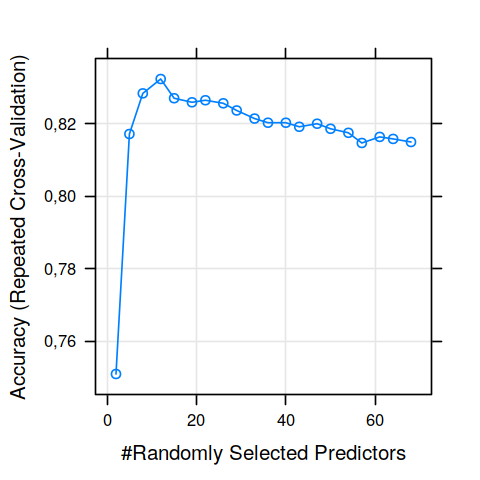

In [120]:
options(repr.plot.width=4, repr.plot.height=4)
plot(rf)

Let's see the accuracy plot with their confidence intervals.

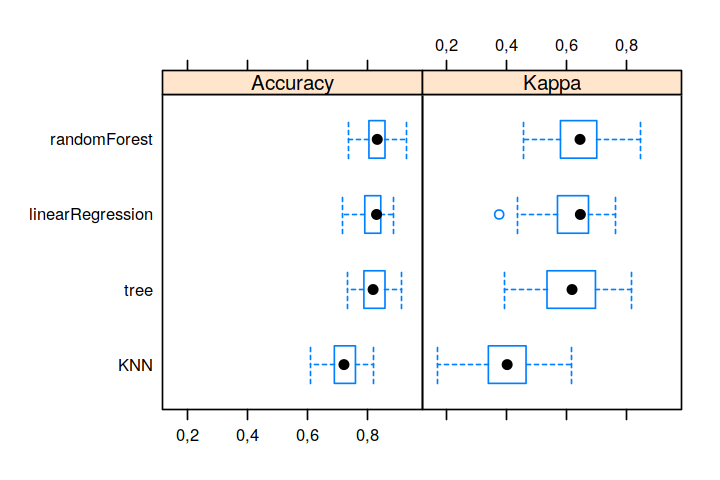

In [121]:
options(repr.plot.width=6, repr.plot.height=4)
resamp <- resamples(list(linearRegression = lr, 
                         KNN = knn,
                         tree = classTree,
                         randomForest = rf
                         )
                    )
bwplot(resamp)

Seeing the Accuracy it's seems that the random Forest is the best method.

Let's move on a **Error Analysis**.

Let's try to see the different calibration plots associated to the best model.

In [122]:
dfPredicted <- data.frame(lr = lr$pred$Not_survived, 
                         tree = classTree$pred$Not_survived[classTree$pred$cp == classTree$bestTune$cp],
                         knn = knn$pred$Not_survived[knn$pred$k == knn$bestTune$k],
                         rf = rf$pred$Not_survived[rf$pred$mtry == rf$bestTune$mtry],
                         obs = lr$pred$obs
                         )

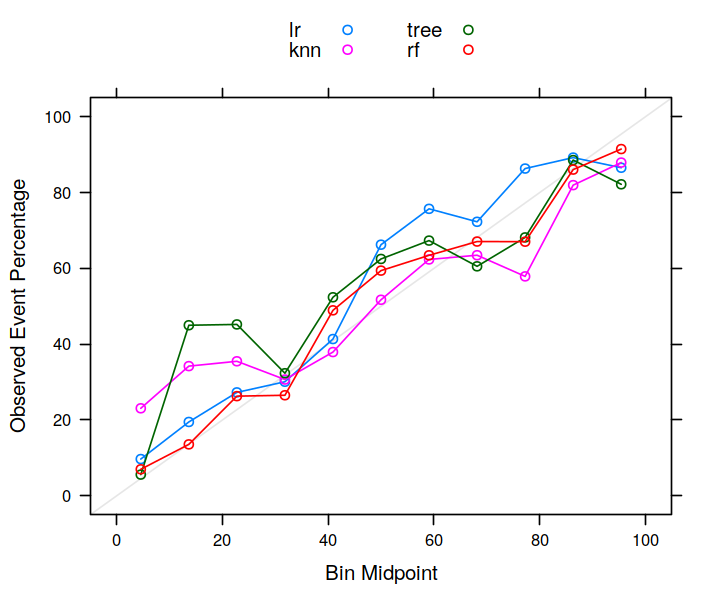

In [123]:
options(repr.plot.width=6, repr.plot.height=5)
cal <- calibration(obs ~ lr + knn + tree + rf, data = dfPredicted)
xyplot(cal, auto.key = list(columns = 2))

We can see that the random forest is the most calibrated model.

We could recalibrate a bit the model but we don't expect big differences. 

The logistic regression is calibrated too.


Let's now see the robustness of the model taking decisions.

We plot the histogram associated to the probability of each Survival class.
 
A robust classifier would clearly split the two classes. 

On the <code>Not_survived</code> histogram we want all the probabilities on the left and on the <code>Survived</code> one all the probability on the right.

In [124]:
lrFinal <-lr$pred
knnFinal <- knn$pred[knn$pred$k == knn$bestTune$k,]
treeFinal <-classTree$pred[classTree$pred$cp == classTree$bestTune$cp,]
rfFinal <- rf$pred[rf$pred$mtry == rf$bestTune$mtry,]

Let's plot the histograms for the different models.

#### Logistic regression

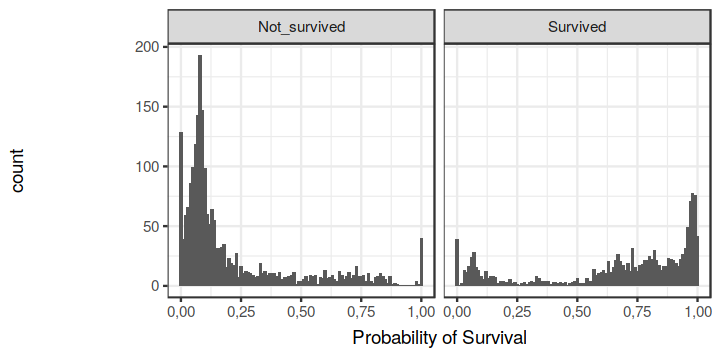

In [125]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(lrFinal,aes(x=Survived))+ 
    geom_histogram(binwidth = 0.01)+
    facet_grid(~obs)+theme_bw() +
    scale_x_continuous(name="Probability of Survival")

#### KNN

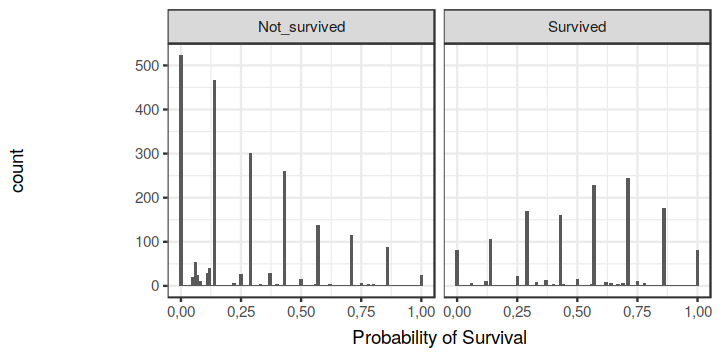

In [126]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(knnFinal,aes(x=Survived))+ 
    geom_histogram(binwidth = 0.01)+
    facet_grid(~obs) +
    theme_bw() +
    scale_x_continuous(name="Probability of Survival")

#### Classification tree

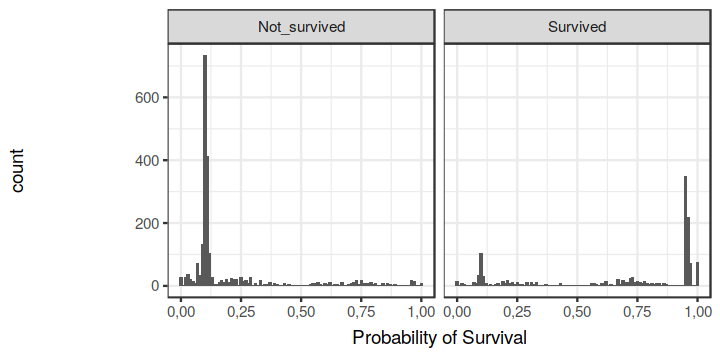

In [127]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(treeFinal,aes(x=Survived))+ 
    geom_histogram(binwidth = 0.01)+
    facet_grid(~obs)+theme_bw()+
    scale_x_continuous(name="Probability of Survival")

#### Random forest

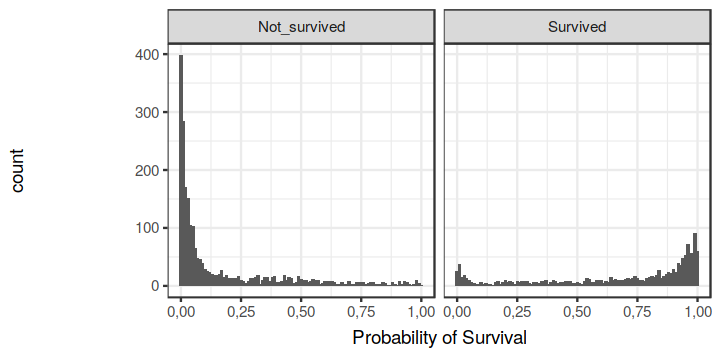

In [128]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(rfFinal,aes(x=Survived))+ 
    geom_histogram(binwidth = 0.01)+
    facet_grid(~obs)+theme_bw()+
    scale_x_continuous(name="Probability of Survival")

We clearly see that the random Forest is the most robust method while the knn the worst one.

Let's finally analyze what kind of errors we have done.

We first start with the confusion matrices, we continue with some measures of the errors and we finish with the ROC and precision/recall curves.

In [129]:
confusionMatrix(data = lrFinal$pred, 
                reference = knnFinal$obs,
                positive = "Survived")

Confusion Matrix and Statistics

              Reference
Prediction     Not_survived Survived
  Not_survived         1879      315
  Survived              321     1055
                                          
               Accuracy : 0,8218          
                 95% CI : (0,8089, 0,8343)
    No Information Rate : 0,6162          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,6236          
                                          
 Mcnemar's Test P-Value : 0,8428          
                                          
            Sensitivity : 0,7701          
            Specificity : 0,8541          
         Pos Pred Value : 0,7667          
         Neg Pred Value : 0,8564          
             Prevalence : 0,3838          
         Detection Rate : 0,2955          
   Detection Prevalence : 0,3854          
      Balanced Accuracy : 0,8121          
                                          
       'Positiv

In [130]:
confusionMatrix(data = knnFinal$pred, 
                reference = knnFinal$obs,
                positive = "Survived")

Confusion Matrix and Statistics

              Reference
Prediction     Not_survived Survived
  Not_survived         1806      589
  Survived              394      781
                                          
               Accuracy : 0,7246          
                 95% CI : (0,7097, 0,7393)
    No Information Rate : 0,6162          
    P-Value [Acc > NIR] : < 2,2e-16       
                                          
                  Kappa : 0,4018          
                                          
 Mcnemar's Test P-Value : 6,107e-10       
                                          
            Sensitivity : 0,5701          
            Specificity : 0,8209          
         Pos Pred Value : 0,6647          
         Neg Pred Value : 0,7541          
             Prevalence : 0,3838          
         Detection Rate : 0,2188          
   Detection Prevalence : 0,3291          
      Balanced Accuracy : 0,6955          
                                          
       'Positiv

In [131]:
confusionMatrix(data = treeFinal$pred, 
                reference = treeFinal$obs,
                positive = "Survived")

Confusion Matrix and Statistics

              Reference
Prediction     Not_survived Survived
  Not_survived         1942      380
  Survived              258      990
                                          
               Accuracy : 0,8213          
                 95% CI : (0,8083, 0,8337)
    No Information Rate : 0,6162          
    P-Value [Acc > NIR] : < 2,2e-16       
                                          
                  Kappa : 0,6157          
                                          
 Mcnemar's Test P-Value : 1,664e-06       
                                          
            Sensitivity : 0,7226          
            Specificity : 0,8827          
         Pos Pred Value : 0,7933          
         Neg Pred Value : 0,8363          
             Prevalence : 0,3838          
         Detection Rate : 0,2773          
   Detection Prevalence : 0,3496          
      Balanced Accuracy : 0,8027          
                                          
       'Positiv

In [132]:
confusionMatrix(data = rfFinal$pred, 
                reference = rfFinal$obs,
                positive = "Survived")

Confusion Matrix and Statistics

              Reference
Prediction     Not_survived Survived
  Not_survived         1952      351
  Survived              248     1019
                                          
               Accuracy : 0,8322          
                 95% CI : (0,8195, 0,8443)
    No Information Rate : 0,6162          
    P-Value [Acc > NIR] : < 2,2e-16       
                                          
                  Kappa : 0,6401          
                                          
 Mcnemar's Test P-Value : 3,078e-05       
                                          
            Sensitivity : 0,7438          
            Specificity : 0,8873          
         Pos Pred Value : 0,8043          
         Neg Pred Value : 0,8476          
             Prevalence : 0,3838          
         Detection Rate : 0,2854          
   Detection Prevalence : 0,3549          
      Balanced Accuracy : 0,8155          
                                          
       'Positiv

As before we can clearly see the random forest is the best model and knn the worst one.

The random forest model has a good sensitivity so it's detecting well the Survival class. 

In addition the Specificity is high too, therefore we can say that it has also found a very good boundary between positive and negative class.

Finally, always seeing the Pos Pred Value and Neg Pred Value we are pretty sure of our models because we don't have a lot of false positive in the first case and a lot of false negative in the last one.

Let's see the AUC associated to the ROC curve.

In [133]:
rocCurvelr <-roc(response = lrFinal$obs,
                 predictor = lrFinal$Survived,
                 levels = levels(lrFinal$obs))
rocCurveKnn <-roc(response = knnFinal$obs,
                 predictor = knnFinal$Survived,
                 levels = levels(knnFinal$obs))
rocCurveTree <-roc(response = treeFinal$obs,
                 predictor = treeFinal$Survived,
                 levels = levels(rfFinal$obs))
rocCurveRf <-roc(response = rfFinal$obs,
               predictor = rfFinal$Survived,
               levels = levels(rfFinal$obs))

Setting direction: controls < cases
Setting direction: controls < cases
Setting direction: controls < cases
Setting direction: controls < cases


In [134]:
print(paste0("AUC for logistic regression is :", auc(rocCurvelr)))
print(paste0("AUC for knn is :", auc(rocCurveKnn)))
print(paste0("AUC for tree is :", auc(rocCurveTree)))
print(paste0("AUC for random Forest is :", auc(rocCurveRf)))

[1] "AUC for logistic regression is :0,838861313868613"
[1] "AUC for knn is :0,756979927007299"
[1] "AUC for tree is :0,840697246184473"
[1] "AUC for random Forest is :0,883788818845388"


Let's also see the confidence interval to see if our estimates are uncertain.

In [135]:
print(paste0("AUC confidence interval for logistic regression is :", paste0(ci(rocCurvelr),collapse = " ") ))
print(paste0("AUC confidence interval for knn is :", paste0(ci(rocCurveKnn),collapse = " ") ))
print(paste0("AUC confidence interval for tree is :", paste0(ci(rocCurveTree),collapse = " ") ))
print(paste0("AUC confidence interval for random Forest is :", paste0(ci(rocCurveRf),collapse = " ") ))

[1] "AUC confidence interval for logistic regression is :0,823888469939403 0,838861313868613 0,853834157797823"
[1] "AUC confidence interval for knn is :0,740891306929761 0,756979927007299 0,773068547084838"
[1] "AUC confidence interval for tree is :0,82543193035726 0,840697246184472 0,855962562011685"
[1] "AUC confidence interval for random Forest is :0,871758005568712 0,883788818845388 0,895819632122065"


Also in this case the random Forest is the best method in the trade-off between sensitivity and specificity.

Let's finally plot the ROC curve for the Random Forest.

In [136]:
predROC <- prediction(rfFinal$Survived, rfFinal$ob)
perfROC <- performance(predROC,"tpr","fpr")

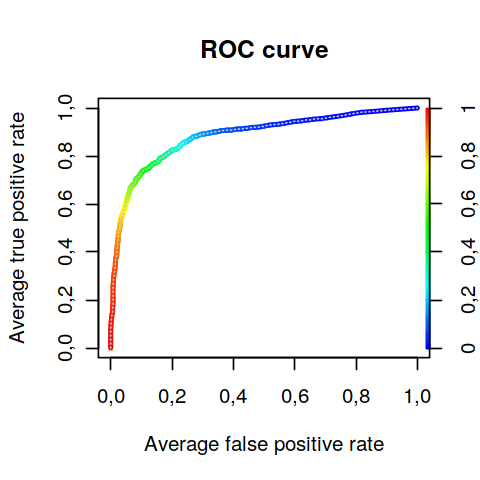

In [137]:
options(repr.plot.width=4, repr.plot.height=4)
plot(perfROC, avg= "threshold", colorize=T, lwd= 3,
   main= "ROC curve")
plot(perfROC, lty=3, col="grey78", add=T)

We see that far from 0.5 of threshold we don't gain too much sensivity and we increase the average false positive rate.

Let's also see the Precision/Recall graph.

In [138]:
pred <- prediction(rfFinal$Survived, rfFinal$ob)
perf <- performance(pred,"prec","rec")
cutoffs <- data.frame(cut=perf@alpha.values[[1]][-1], recall=perf@x.values[[1]][-1], 
                      precision=perf@y.values[[1]][-1])


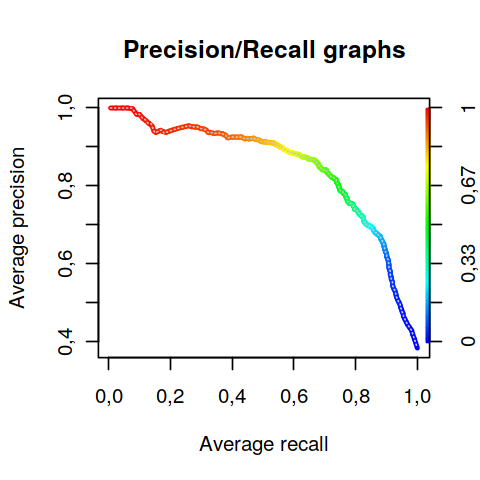

In [139]:
options(repr.plot.width=4, repr.plot.height=4)
plot(perf, avg= "threshold", colorize=T, lwd= 3,
   main= "Precision/Recall graphs")
plot(perf, lty=3, col="grey78", add=T)


In this case too a big gradient is present when we are around a recal of 0.7, so a good threshold can be 0.5.

It's seems that from this two plots the best choice for the threshold is 0.5. It makes sense because we are working with a balanced dataset.

For the sake of completeness we can see the behaviour of Precision and recall against the threshold.

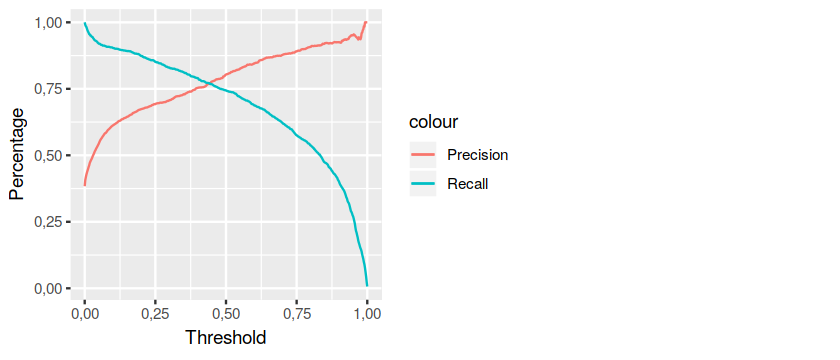

In [140]:
options(repr.plot.width=7, repr.plot.height=3)
ggplot(cutoffs, aes(cut)) + 
  geom_line(aes(y = precision, colour = "Precision")) + 
  geom_line(aes(y = recall, colour = "Recall")) +
  labs(y="Percentage", x = "Threshold")

Last final thing we want to see is the feature importance of the 10 most important variables.

In [141]:
varValue <- varImp(rf)$importance[order(varImp(rf)$importance$Overall, decreasing = TRUE),][1:10]
varNames <- rownames(varImp(rf)$importance)[order(varImp(rf)$importance$Overall, decreasing = TRUE)][1:10]
varImpName <- data.frame(values = varValue, names = varNames)
rankImportance <- varImpName %>%
  mutate(Rank = paste0('#',dense_rank(desc(varValue))))

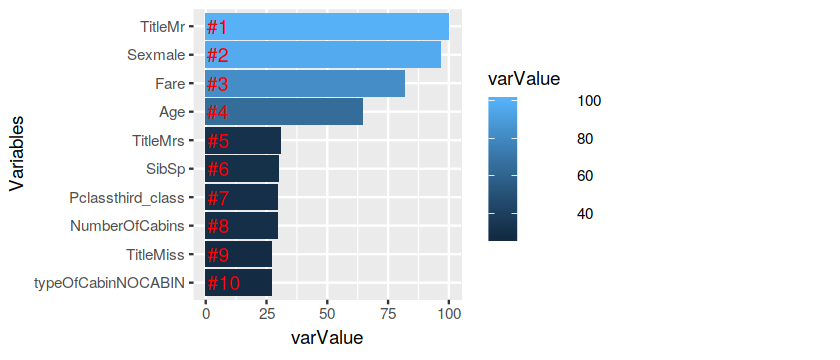

In [142]:
options(repr.plot.width=7, repr.plot.height=3)

ggplot(rankImportance, aes(x = reorder(varNames, varValue), 
    y = varValue, fill = varValue)) +
  geom_bar(stat='identity') + 
  geom_text(aes(x = varNames, y = 0.5, label = Rank),
    hjust=0, vjust=0.55, size = 4, colour = 'red') +
  labs(x = 'Variables') +
  coord_flip() 


We see that the title for Mr seems very important.

In addition we see that the sex and the class seems to be important as we have seen in the data visualization analysis. 

The number of Cabin is important too.

Our feature engineering has been useful!

## 1.5 Predict new values

We finally estimate the test error with our validation set we have created at the beginning using the random forest as predicting model.

In [143]:
prediction <- predict(rf, testSetPrep %>% select(-Survived))

In [144]:
postResample(prediction, testSetPrep$Survived)

Accuracy     Kappa 
0,7796610 0,5431805

In [145]:
cM <- confusionMatrix(data = prediction  %>% as.factor,
               reference = testSetPrep$Survived,
                positive = "Survived")

In [146]:
PresenceAbsence::sensitivity(cM$table)

sensitivity,sensitivity.sd
"0,7889908","0,03926221"


In [147]:
PresenceAbsence::specificity(cM$table)

specificity,specificity.sd
"0,7647059","0,05182214"


Similar from our cross-validated estimation in the previous phase.

We are ready to train our algorithm on the entire training set and predict the prediction set.

In [148]:
ctrlFinal <- trainControl(method = "none", 
                          classProbs = TRUE,
                          savePred = TRUE
                          )

In [149]:
rfFinal <- train(Survived ~ ., 
            data = bind_rows(learningSetFilled, testSetPrep),
            method = 'rf', 
            trControl = ctrlFinal,
            metric = metric,
            tunegrid = expand.grid(.mtry = rf$bestTune$mtry)
           )

In [150]:
rfFinal

Random Forest 

891 samples
 11 predictor
  2 classes: 'Not_survived', 'Survived' 

No pre-processing
Resampling: None 

So now we have to transform our predict set.

In [166]:
toPredictSet$Pclass %<>% as.factor
toPredictSet$Sex %<>% as.factor
toPredictSet$Sex %<>% as.factor
toPredictSet$Embarked %<>% as.factor

toPredictSet$Age %<>% as.numeric
toPredictSet$Fare %<>% as.numeric

toPredictSet$Title <- unlist(lapply(strsplit(toPredictSet$Name,split=",") ,
                         FUN= function(name) {
                         str_trim(strsplit(name[2],split="\\.")[[1]][1])
                         })
                         )
toPredictSet$Title  %<>% as.factor 
toPredictSet %<>% select(-Name)

toPredictSet$Embarked[toPredictSet$Embarked == ""] <- NA

toPredictSet$TypeTicket <- map_chr(strsplit(toPredictSet$Ticket, split = " "), 
                                function(var){
                                    if(length(var) == 2)
                                        return (var[1])
                                    else return("")
                                }
                                )
toPredictSet$TypeTicket <- gsub("\\.", "", toPredictSet$TypeTicket)
toPredictSet$TypeTicket <- gsub("/", "", toPredictSet$TypeTicket )
toPredictSet$TypeTicket %<>% as.factor 
toPredictSet %<>% select(-Ticket)

toPredictSet %<>% mutate(NumberOfCabins = 0, typeOfCabin = NA)
for (i in 1 : nrow(toPredictSet)){
    cabin <- toPredictSet$Cabin[i]
    if(cabin != ""){
        num <- strsplit(cabin, split = " ")[[1]]
        toPredictSet$NumberOfCabins[i] <- length(num)
        if(toPredictSet$NumberOfCabins[i] == 1){
            toPredictSet$typeOfCabin[i] <- gsub('[[:digit:]]+', '', num)
        }else if(toPredictSet$NumberOfCabins[i] > 1){
            numNoDigit <- gsub('[[:digit:]]+', '', num[1])
            toPredictSet$typeOfCabin[i] <- numNoDigit
        }else{
            toPredictSet$typeOfCabin[i] <- "NOLETTER"
        }
    }else{
        toPredictSet$NumberOfCabins[i] <- 0
        toPredictSet$typeOfCabin[i] <- "NOCABIN"
    }
}
toPredictSet %<>% select(-Cabin)
toPredictSet$typeOfCabin %<>% as.factor 

In [167]:
colSums(is.na(toPredictSet))

PassengerId         Pclass            Sex            Age          SibSp 
             0              0              0             86              0 
         Parch           Fare       Embarked          Title     TypeTicket 
             0              1              0              0              0 
NumberOfCabins    typeOfCabin 
             0              0

In this case we have to fill the <code>Fare</code> variable too and we can use the mean because it's only a missing value.

In [168]:
toPredictSet$Fare[is.na(toPredictSet$Fare)] <- mean(learningSetFilled$Fare)

In [169]:
str(toPredictSet)

'data.frame':	418 obs. of  12 variables:
 $ PassengerId   : int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass        : Factor w/ 3 levels "1","2","3": 3 3 2 3 3 3 3 2 3 3 ...
 $ Sex           : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age           : num  34,5 47,0 62,0 27,0 22,0 14,0 30,0 26,0 18,0 21,0 ...
 $ SibSp         : int  0 1 0 0 1 0 0 1 0 2 ...
 $ Parch         : int  0 0 0 0 1 0 0 1 0 0 ...
 $ Fare          : num  7,83 7,00 9,69 8,66 12,29 ...
 $ Embarked      : Factor w/ 3 levels "C","Q","S": 2 3 2 3 3 3 2 3 1 3 ...
 $ Title         : Factor w/ 9 levels "Col","Dona","Dr",..: 6 7 6 6 7 6 5 6 7 6 ...
 $ TypeTicket    : Factor w/ 26 levels "","A4","A5","AQ3",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ NumberOfCabins: num  0 0 0 0 0 0 0 0 0 0 ...
 $ typeOfCabin   : Factor w/ 8 levels "A","B","C","D",..: 8 8 8 8 8 8 8 8 8 8 ...


Let's do the same pre-processing part we have done before.

In [170]:
toPredictSet$Pclass <- plyr::revalue(toPredictSet$Pclass,
                                          c("1"="first_class", "2"="second_class", "3" = "third_class")
                                         )

In [171]:
toPredictSetFilled <- toPredictSet
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "female" &
                  toPredictSetFilled$Pclass=="first_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" & 
                                                                       meanByGroup$Pclass == "1"]
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "female" &
                  toPredictSetFilled$Pclass=="second_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" & 
                                                                       meanByGroup$Pclass == "2"]
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "female" &
                  toPredictSetFilled$Pclass=="third_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "female" &
                                                                       meanByGroup$Pclass == "3"]
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "male" &
                  toPredictSetFilled$Pclass=="first_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "1"]
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "male" & 
                  toPredictSetFilled$Pclass=="second_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "2"]
toPredictSetFilled$Age[is.na(toPredictSetFilled$Age) &
                  toPredictSetFilled$Sex == "male" &
                  toPredictSetFilled$Pclass=="third_class"] <- meanByGroup$meadianAge[meanByGroup$Sex == "male" &
                                                                       meanByGroup$Pclass == "3"]

In [172]:
toPredictSetFilled$Fare <- toPredictSetFilled$Fare + 1
toPredictSetFilled$SibSp <- toPredictSetFilled$SibSp + 1
toPredictSetFilled$Parch <- toPredictSetFilled$Parch + 1

In [173]:
toPredictSetPred <- predict(trans, toPredictSetFilled)

In [174]:
str(toPredictSetPred)

'data.frame':	418 obs. of  12 variables:
 $ PassengerId   : int  892 893 894 895 896 897 898 899 900 901 ...
 $ Pclass        : Factor w/ 3 levels "first_class",..: 3 3 2 3 3 3 3 2 3 3 ...
 $ Sex           : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
 $ Age           : num  0,395 1,334 2,461 -0,169 -0,544 ...
 $ SibSp         : num  -0,694 1,293 -0,694 -0,694 1,293 ...
 $ Parch         : num  -0,558 -0,558 -0,558 -0,558 1,573 ...
 $ Fare          : num  -0,830 -0,933 -0,631 -0,736 -0,404 ...
 $ Embarked      : Factor w/ 3 levels "C","Q","S": 2 3 2 3 3 3 2 3 1 3 ...
 $ Title         : Factor w/ 9 levels "Col","Dona","Dr",..: 6 7 6 6 7 6 5 6 7 6 ...
 $ TypeTicket    : Factor w/ 26 levels "","A4","A5","AQ3",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ NumberOfCabins: num  -0,506 -0,506 -0,506 -0,506 -0,506 ...
 $ typeOfCabin   : Factor w/ 8 levels "A","B","C","D",..: 8 8 8 8 8 8 8 8 8 8 ...


Let's predict the predict set with the random forest.

In [175]:
toPredict <- predict(rfFinal, toPredictSetPred %>% select(-PassengerId))

In [176]:
dfPrev <- data.frame(PassengerId = toPredictSetPred$PassengerId,  Survived = toPredict)

In [177]:
dfPrev$Survived <- plyr::revalue(dfPrev$Survived,
                                            c("Not_survived"="0", "Survived"="1")
                                           )

In [178]:
write.csv(dfPrev, "/home/julien/My_Programs/kaggle-titanic/results.csv",row.names = FALSE)

With this analysis we obtain an accuracy of **0.78229**, pretty similar to our validation set! 

We have just constructed a robust and precise model!